<a href="https://colab.research.google.com/github/iam-Dylan/automated-essay-scoring/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Learning Agency Lab - Automated Essay Scoring 2.0

- Môn học: Phân tích dữ liệu thông minh
- Nhóm: 10

# **EDA (Exploratory Data Analysis)**

##  **A. Bối cảnh dữ liệu**

- **Cuộc thi chấm điểm bài luận tự động** nhằm hướng đến giải quyết vấn đề chấm điểm tự động các bài luận của học sinh. Với bộ dữ liệu được cập nhật và nhiều ý tưởng mới mẻ, cuộc thi hy vọng có thể đạt được những tiến bộ mới nhất trong việc chấm điểm tự động để mang lại ảnh hưởng thực sự tích cực đối với những giáo viên đang quá tải, những người vẫn tiếp tục gặp khó khăn trong việc cung cấp phản hồi kịp thời, đặc biệt là trong bối cảnh thiếu thốn nhân lực.

- **Mục tiêu của cuộc thi** này là huấn luyện một mô hình để chấm điểm các bài luận của học sinh. Nỗ lực là cần thiết để giảm bớt chi phí cao và thời gian cần thiết để chấm các bài luận bằng tay. Các kỹ thuật chấm điểm tự động đáng tin cậy có thể cho phép đưa các bài luận vào trong các kỳ kiểm tra, một chỉ số quan trọng về sự học tập của học sinh mà hiện nay thường bị tránh do những thách thức trong việc chấm điểm.

- Bộ dữ liệu được công khai trên này tảng Kaggle, thông tin chi tiết có thể tìm hiểu tại: [Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2)

## **B. Tiền xử lý dữ liệu**

### **1. Import các thư viện cần thiết**


In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop=set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### **2. Đọc dữ liệu**

- Để dễ dàng đồng bộ đường dẫn, nhóm sẽ thực hiện download file csv trực tiếp từ Google Drive.

In [2]:
# URL tải xuống trực tiếp của tệp CSV trên Google Drive
FILEID = '1hUhF4f-gGTixo_-b-ytez01_swNBslIG'
url = f"https://drive.google.com/uc?export=download&id={FILEID}"
# Đọc tệp CSV từ URL
try:
    train = pd.read_csv(url)
    train.head()
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")
data = train.copy()
data.head()

essay_id                                          full_text  score
0  000d118  Many people have car where they live. The thin...      3
1  000fe60  I am a scientist at NASA that is discussing th...      3
2  001ab80  People always wish they had the same technolog...      4
3  001bdc0  We all heard about Venus, the planet without a...      4
4  002ba53  Dear, State Senator\n\nThis is a letter to arg...      3

### **3. Tổng quan dữ liệu**

In [3]:
# Hiển thị thông tin cơ bản
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


**Thông tin cơ bản về dữ liệu:**
- Số lượng dòng: 17,307
- Số lượng cột: 3
- Tên các cột và kiểu dữ liệu:
  - **essay_id (object):** mã định danh duy nhất cho mỗi bài luận.
  - **full_text (object):** nội dung bài luận.
  - **score (int64):** điểm tổng thể của bài luận theo thang điểm 1-6.

In [4]:
# Kiểm tra các giá trị bị thiếu
data.isnull().sum()

essay_id     0
full_text    0
score        0
dtype: int64

- Dữ liệu không tồn tại cột nào xảy ra hiện tượng mất mát dữ liệu.

In [5]:
# Kiểm tra trùng lặp dữ liệu
data.duplicated().sum()

0

+ Dữ liệu không có dòng bị trùng lặp, ta không cần xử lý thêm.

**Phân bố giá trị dữ liệu**

- Các thuộc tính **numeric**:

In [6]:
data.select_dtypes(include="number").describe()

score
count  17307.000000
mean       2.948402
std        1.044899
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        6.000000

- Các thuộc tính **categorical**

In [7]:
data.select_dtypes(include="object").describe()

essay_id                                          full_text
count     17307                                              17307
unique    17307                                              17307
top     000d118  Many people have car where they live. The thin...
freq          1                                                  1

### **4. Tiền xử lý dữ liệu**

Cần **làm sạch văn bản**, nhằm chuẩn hóa và loại bỏ những thành phần không cần thiết trước khi tiến hành các bước xử lý tiếp theo.

- Văn bản được chuyển đổi toàn bộ về **chữ thường** để đảm bảo tính nhất quán và tránh phân biệt giữa chữ hoa và chữ thường.
- Các **thẻ HTML**, thẻ tên người dùng (bắt đầu bằng @), **hashtag** (bắt đầu bằng #), và đường dẫn **URL** đều được loại bỏ để giữ lại nội dung văn bản thực sự.
- Các **ký tự đặc biệt** và các **số** trong văn bản, thường không mang lại giá trị ngữ nghĩa, cũng được loại bỏ.
- Các **dấu câu liên tiếp** được xử lý và thay thế bằng một ký tự duy nhất.
- Các **từ viết tắt** được mở rộng thành dạng đầy đủ để đảm bảo tính nhất quán.

In [8]:
data['full_text'][1]

'I am a scientist at NASA that is discussing the "face" on mars. I will be explaining how the "face" is a land form. By sharing my information about this isue i will tell you just that.\n\nFirst off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this.\n\nNext, why it is a landform. There are many landforms that are weird here in America, and there is also landforms all around the whole Earth. Many of them look like something we can relate to like a snake a turtle a human... So if there are landforms on earth dont you think landforms are on mars to? Of course! why not? It\'s just unique that the landform on Mars looks like a human face. Also if there was martians and they were trying to get our attention dont y

In [9]:
def expand_contractions(text):
    contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have","he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is",
    "let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have",
    "must've": "must have","mustn't": "must not","mustn't've": "must not have",
    "needn't": "need not","needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not","oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
    "should've": "should have","shouldn't": "should not","shouldn't've": "should not have",
    "so've": "so have","so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have","that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have","there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have",
    "to've": "to have","wasn't": "was not","weren't": "were not",
    "we'd": "we had",
    "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
    "what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is","what've": "what have",
    "when's": "when is","when've": "when have",
    "where'd": "where did","where's": "where is","where've": "where have",
    "who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
    "will've": "will have","won't": "will not","won't've": "will not have",
    "would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
    "y'all": "you all","y'alls": "you alls","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
    "y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have",
    "you're": "you are",  "you've": "you have"
    }
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    return contractions_re.sub(lambda match: contractions_dict[match.group(0)], text)

def clean_text(text):
    text = text.lower()
    text = re.compile(r'<.*?>').sub(r'', text)
    text = re.sub(r'@\w+\s*', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = text.replace(u'\xa0', ' ')
    text = re.sub(r'\d+', '', text)
    text = expand_contractions(text)
    text = re.sub(r'\.+', '.', text)
    text = re.sub(r'\,+', ',', text)
    text = text.strip()

    return text

data['full_text'] = data['full_text'].apply(clean_text)

## **C. Khám phá và phân tích dữ liệu**

### **1. Phân phối cột `score`**

In [10]:
score = data['score'].value_counts()
score

score
3    6280
2    4723
4    3926
1    1252
5     970
6     156
Name: count, dtype: int64

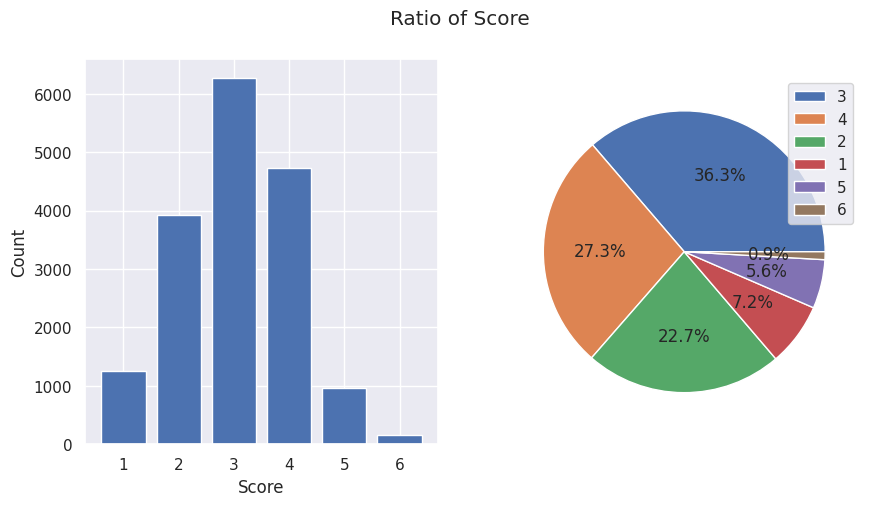

In [11]:
# Tỉ lệ phân bố điểm
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(data['score'].unique(), data['score'].value_counts())
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Count')

ax[1].pie(data['score'].value_counts(), autopct='%1.1f%%')
ax[1].legend(labels = data['score'].unique(), loc = 'upper right')
fig.suptitle('Ratio of Score')
plt.show()

**Nhận xét:**

- Phân bố điểm trong lớp có dạng gần với phân phối chuẩn.
- Số lượng các bài đạt điểm tối đa không cao chưa đến 1% (khoảng 170 bài), ít hơn 10 lần bài đạt điểm 1 và gần 60 lần bài đạt điểm trung bình.
- Điểm có số lượng bài đạt được nhiều nhất là 3, chiếm 1/3 số bài.
- Khoảng điểm [2-4] chiếm số lượng nhiều hơn các khác còn lại, khoảng 50%.

#### **Tạo thêm cột `high_score`**
Để thuận tiện hơn trong quá trình khám phá dữ liệu cũng như kết hợp với một số kiểm định, ta sẽ gom dữ liệu thành 2 nhóm và tạo thêm cột `high_score`, cụ thể:
  + Các bài đạt điểm 1, 2 và 3 sẽ chung một nhóm với giá trị cột `high_score` = 0
  + Các bài đạt điểm 4, 5 và 6 sẽ chung một nhóm với giá trị cột `high_score` = 1

In [12]:
data['high_score'] = data['score'].apply(lambda x: 0 if x in [1, 2, 3] else (1 if x in [4, 5, 6] else None))
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  
0           0  
1           0  
2           1  
3           1  
4           0

### **2. Độ dài bài luận (số lượng ký tự)**

In [13]:
# Tạo thêm cột mới
data['len_text'] = data['full_text'].str.len() ;
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  len_text  
0           0      2652  
1           0      1670  
2           1      3068  
3           1      2686  
4           0      2190

In [14]:
character_number_describe = data['len_text'].describe()
character_number_describe

count    17307.000000
mean      2046.712949
std        864.438589
min        711.000000
25%       1385.000000
50%       1908.000000
75%       2522.000000
max       8064.000000
Name: len_text, dtype: float64

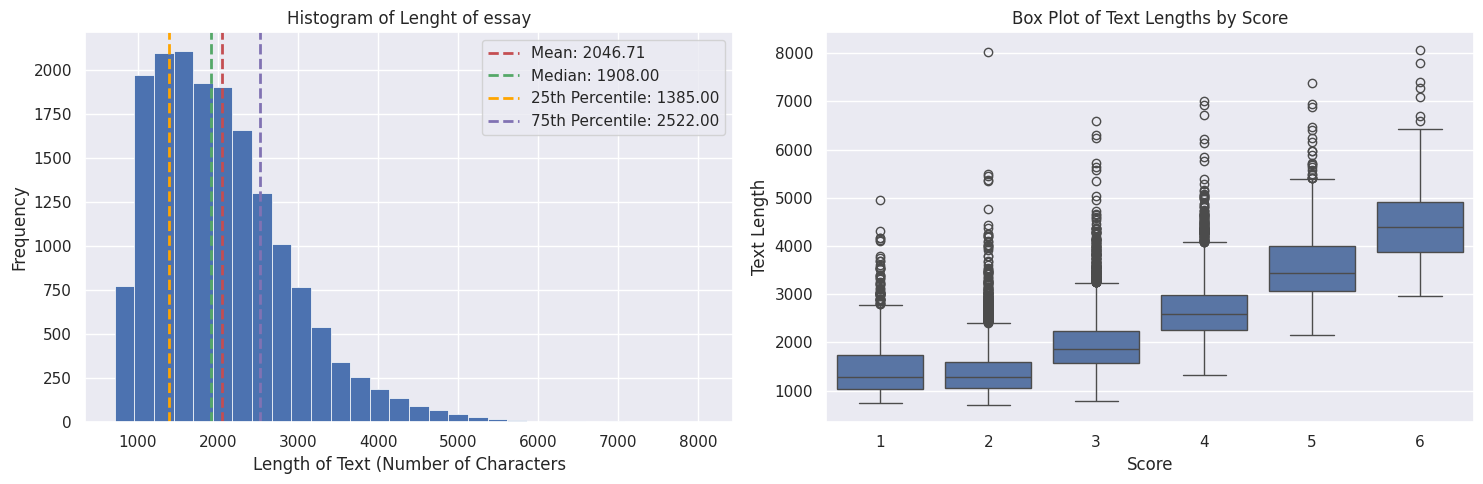

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(data['len_text'], bins=30, edgecolor='w', linewidth=0.5)
median_word_count = data['len_text'].median()
mean_word_count = data['len_text'].mean()
percentile_25 = np.percentile(data['len_text'], 25)
percentile_75 = np.percentile(data['len_text'], 75)
ax[0].set_title('Histogram of Lenght of essay')
ax[0].set_xlabel('Length of Text (Number of Characters')
ax[0].set_ylabel('Frequency')
ax[0].axvline(mean_word_count, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_word_count:.2f}')
ax[0].axvline(median_word_count, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_word_count:.2f}')
ax[0].axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
ax[0].axvline(percentile_75, color='m', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
ax[0].legend()

sns.boxplot(x='score', y='len_text', data=data, ax=ax[1])
ax[1].set_title('Box Plot of Text Lengths by Score')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('Text Length')

plt.tight_layout()
# plt.savefig('chart/len_text.svg')
plt.show()

**Nhận xét:**

- Phân phối độ dài đoạn văn bị lệch về phía dương vì **mean > median**.
- Số lượng kí từ trong mỗi đoạn văn phần lớn dao động từ 1000 - 2500, chiếm 75% số bài.
- Có một số ít đoạn văn rất dài, từ 5000 kí tự trở lên.
- Theo boxplot, dường như có mối quan hệ giữa điểm số và độ dài đoạn văn, **đoạn văn càng dài → điểm càng cao**.

#### **Chuẩn bị hàm cho các bước khám phá sau hơn**

- Hàm vẽ đồ thị histogram cho mỗi điểm ứng với một số đặc trưng của bài văn.

In [16]:
def histogram_each_score(data, column_name, title):
    unique_scores = sorted(data['score'].unique())
    num_scores = len(unique_scores)

    fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True)
    fig.tight_layout(pad=5.0)

    for i, score in enumerate(unique_scores):
        row = i // 3
        col = i % 3
        score_data = data[data['score'] == score]
        mean_char_count = score_data[column_name].mean()
        std_char_count = score_data[column_name].std()

        axes[row, col].hist(score_data[column_name], bins=30, edgecolor='black', alpha=0.7)
        axes[row, col].axvline(mean_char_count, color='r', linestyle='dashed', linewidth=1)
        axes[row, col].axvline(mean_char_count + std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[row, col].axvline(mean_char_count - std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[row, col].set_title(f'Score: {score} (mean={mean_char_count:.2f}, sd={std_char_count:.2f})')
        axes[row, col].set_xlabel(title)
        axes[row, col].set_ylabel('Frequency')

    for j in range(num_scores, 9):
        row = j // 3
        col = j % 3
        fig.delaxes(axes[row, col])
    # plt.savefig(f'chart/histogram_{title}.svg')
    plt.show()

- Hàm vẽ histogram và distribution dựa trên cột `high_score` và một đặc trưng khác.

In [17]:
def chart_high_score(data, column_name, title):
    unique_scores = sorted(data['high_score'].unique())
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

    for i, score in enumerate(unique_scores):
        high_score_data = data[data['high_score'] == score]
        mean_char_count = high_score_data[column_name].mean()
        std_char_count = high_score_data[column_name].std()

        axes[i].hist(high_score_data[column_name], bins=30, edgecolor='black', alpha=0.7)
        axes[i].axvline(mean_char_count, color='r', linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_char_count + std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[i].axvline(mean_char_count - std_char_count, color='g', linestyle='dashed', linewidth=1)
        axes[i].set_title(f'Score: {score} (mean={mean_char_count:.2f}, sd={std_char_count:.2f})')
        axes[i].set_xlabel(title)
        axes[i].set_ylabel('Frequency')

    sns.kdeplot(data=data, x=column_name, hue='high_score', palette=['red', 'green'], ax=axes[2])
    axes[2].set_title('Distribution of' + title + ' by Score')
    axes[2].set_xlabel(title)
    axes[2].set_ylabel('Density')

    plt.tight_layout()
    # plt.savefig(f'chart/high_score_{title}.svg')
    plt.show()

- Hàm kiểm định giả thuyết.

In [18]:
from scipy import stats
def accreditation(data, column_name, type):
  alpha = 0.05
  t_statistic, p_value = stats.ttest_ind(data[data['high_score'] == 1][column_name], data[data['high_score'] == 0][column_name], alternative=type)

  print("t-statistic = ", t_statistic)


  print("p-value = ", p_value)
  if p_value <= alpha:
      print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
  else:
      print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

#### **Phân tích theo từng mức điểm**

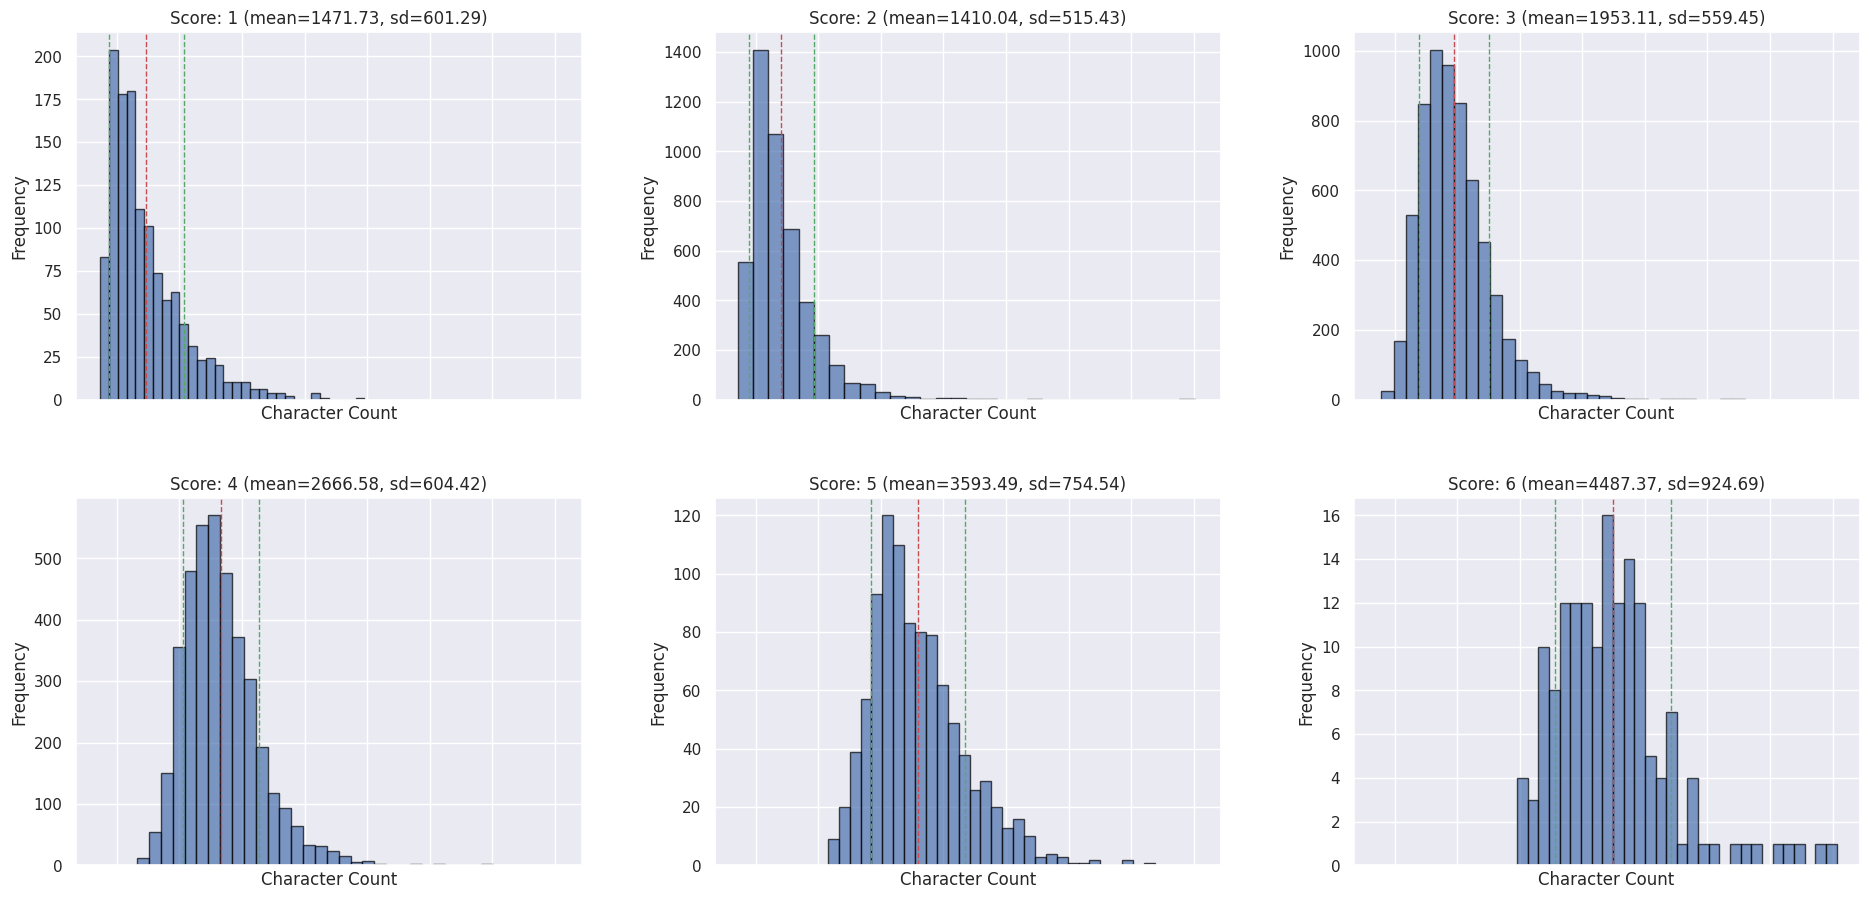

In [19]:
histogram_each_score(data, 'len_text', 'Character Count')

**Nhận xét:**  Khi phân tích sự phân bố của các bài văn dựa theo từng mức điểm riêng lẻ thì đa phần các bài văn có đạt điểm 1, 2 và 3 có số lượng các ký tự ít hơn các bài văn đạt điểm 4, 5 và 6.

Ta không biết được rằng liệu các bài viết đạt điểm 1, 2, 3 sẽ có số lượng
ký tự ít hơn các bài đạt điểm 4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng ký tự không ít hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng ký tự ít hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [20]:
accreditation(data, 'len_text', "greater")

t-statistic =  107.9514337931287
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Do đó, ta có thể kết luận rằng các bài văn thuộc nhóm `high_score` = 1 (bài văn đạt điểm 4, 5, 6) có số lượng ký tượng nhiều hơn các bài thuộc nhóm còn lại (bài văn đạt điểm 1, 2, 3) với độ tin cậy 95%

### **3. Số lượng từ**

In [21]:
def word_count(df):
    df = df.split()
    return len(df)

data['word_count'] = data['full_text'].agg(word_count)
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  len_text  word_count  
0           0      2652         494  
1           0      1670         335  
2           1      3068         550  
3           1      2686         448  
4           0      2190         373

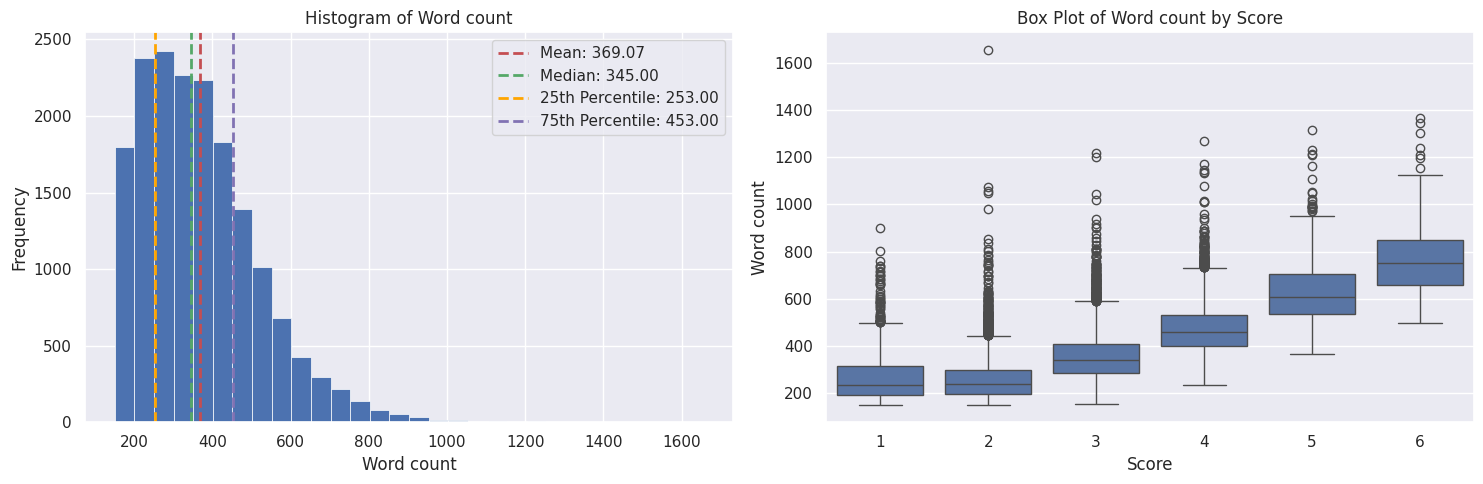

In [22]:
median_word_count = data['word_count'].median()
mean_word_count = data['word_count'].mean()
percentile_25 = np.percentile(data['word_count'], 25)
percentile_75 = np.percentile(data['word_count'], 75)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(data['word_count'], bins=30, edgecolor='w', linewidth=0.5)
ax[0].set_title('Histogram of Word count')
ax[0].set_xlabel('Word count')
ax[0].set_ylabel('Frequency')
ax[0].axvline(mean_word_count, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_word_count:.2f}')
ax[0].axvline(median_word_count, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_word_count:.2f}')
ax[0].axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
ax[0].axvline(percentile_75, color='m', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
ax[0].legend()


sns.set_theme(style="darkgrid")
sns.boxplot(x='score', y='word_count', data=data, ax=ax[1])
ax[1].set_title('Box Plot of Word count by Score')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('Word count')

plt.tight_layout()
# plt.savefig('chart/word_count.svg')
plt.show()

**Nhận xét:**

- Phân phối số từ trong đoạn văn bị lệch về phía dương vì **mean > median**.
- Số lượng từ trong mỗi đoạn văn dao động từ 13 đến 1024.
- Đa số các đoạn văn có số lượng từ từ 200 đến 400, chiếm 75% số bài.
- Có một số ít đoạn văn có số lượng từ rất ngắn (dưới 100) hoặc rất dài (trên 800).
- Theo boxplot, dường như có mối quan hệ giữa điểm số và số lượng từ, **số từ càng nhiều → điểm càng cao**.

#### **Trung bình độ dài từ**

In [23]:
data['mean_word_length'] = data['full_text'].map(lambda text: np.mean([len(word) for word in text.split()]))
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  len_text  word_count  mean_word_length  
0           0      2652         494          4.356275  
1           0      1670         335          3.976119  
2           1      3068         550          4.574545  
3           1      2686         448          4.977679  
4           0      2190         373          4.857909

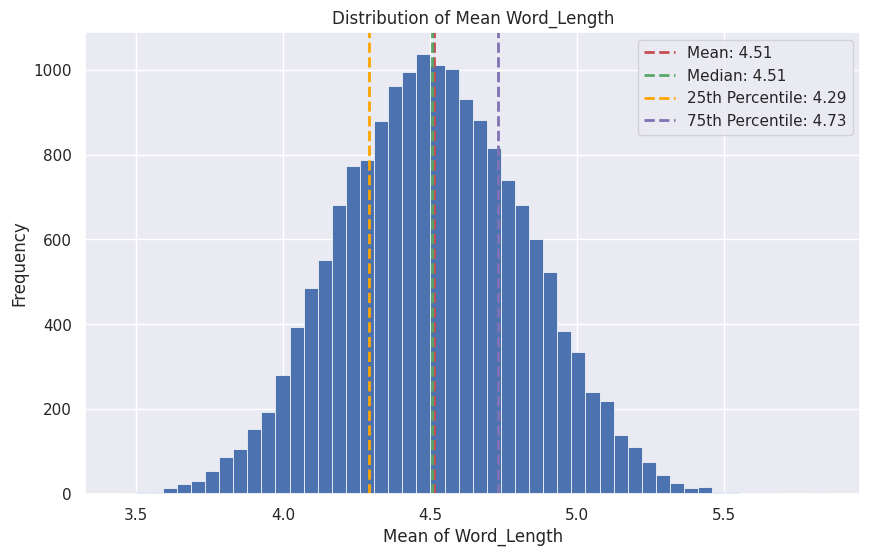

In [24]:
mean_val = data['mean_word_length'].mean()
median_val = data['mean_word_length'].median()
percentile_25 = np.percentile(data['mean_word_length'], 25)
percentile_75 = np.percentile(data['mean_word_length'], 75)

plt.figure(figsize=(10, 6))
plt.hist(data['mean_word_length'], bins=50, edgecolor='w', linewidth=0.5)
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='m', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Distribution of Mean Word_Length')
plt.xlabel('Mean of Word_Length')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('chart/mean_word_len.svg')
plt.show()

**Nhận xét:**

- Đồ thị có dạng phân phối chuẩn, không bị lệch.
- Phần lớn các bài đều có trung bình độ dài từ nằm trong khoảng từ 4.3 - 4.7.

#### **Phân tích theo từng mức điểm**

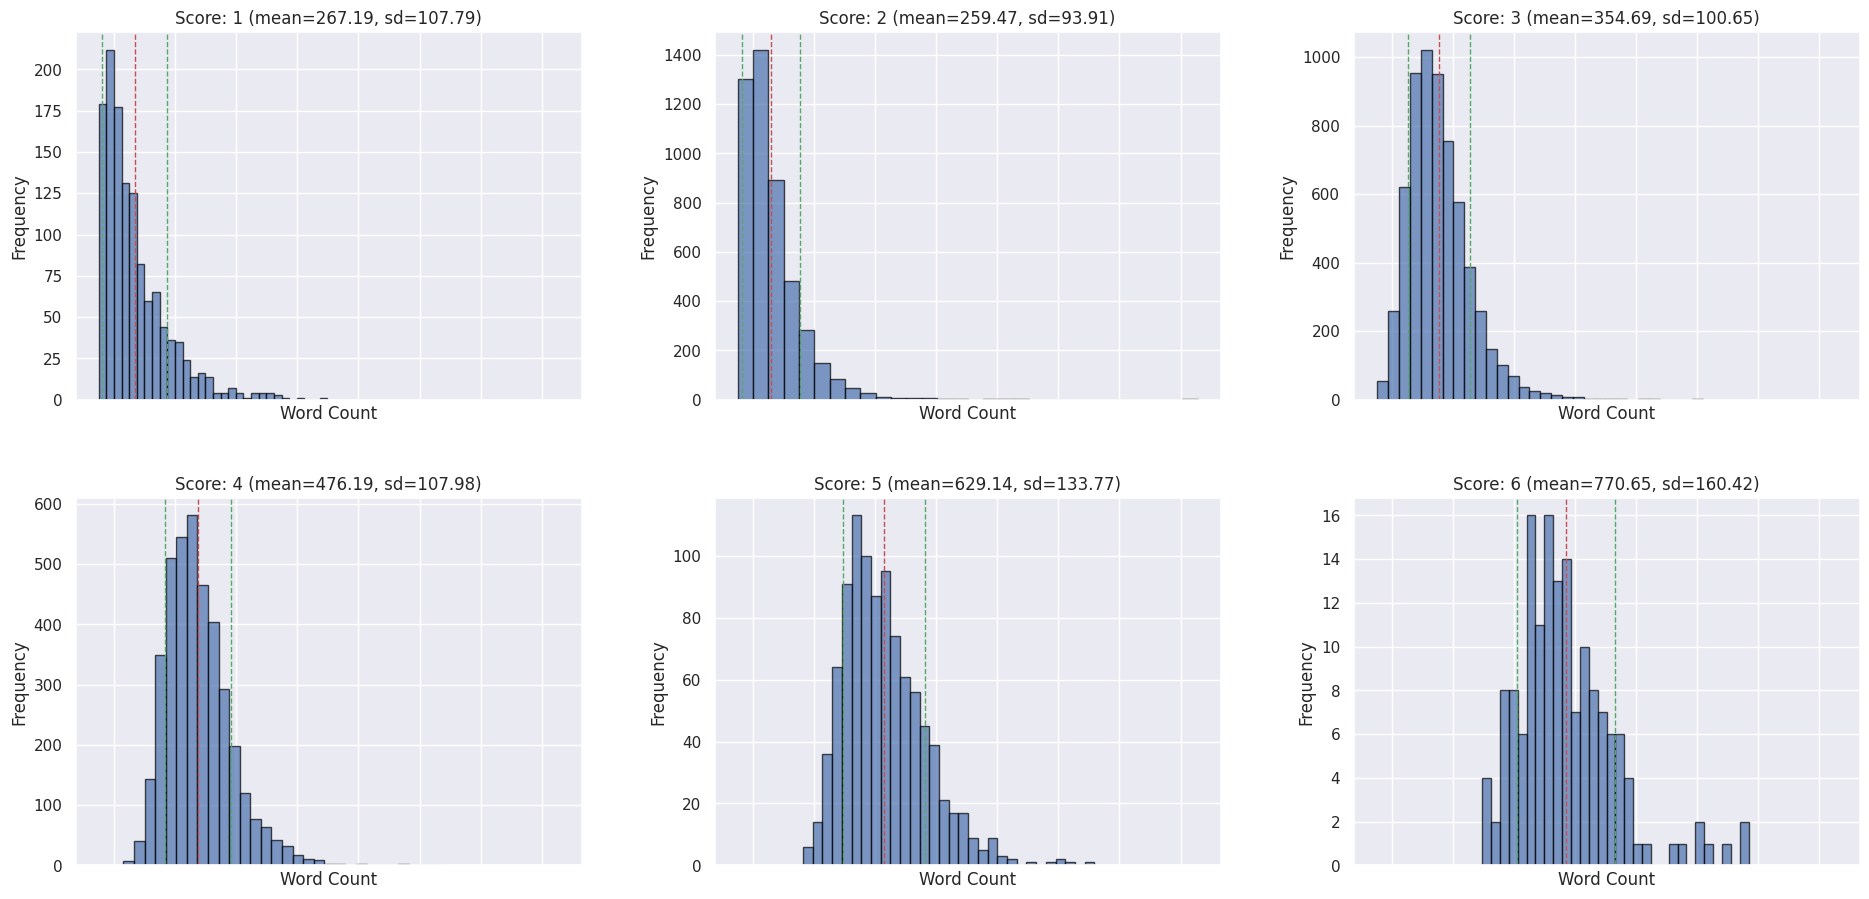

In [25]:
histogram_each_score(data, 'word_count', 'Word Count')

**Nhận xét:**

- Ta thấy giá trị trung bình số từ của điểm 1, 2, 3 đều nhỏ hơn điểm 4, 5, 6.
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về số lượng từ của các bài văn.

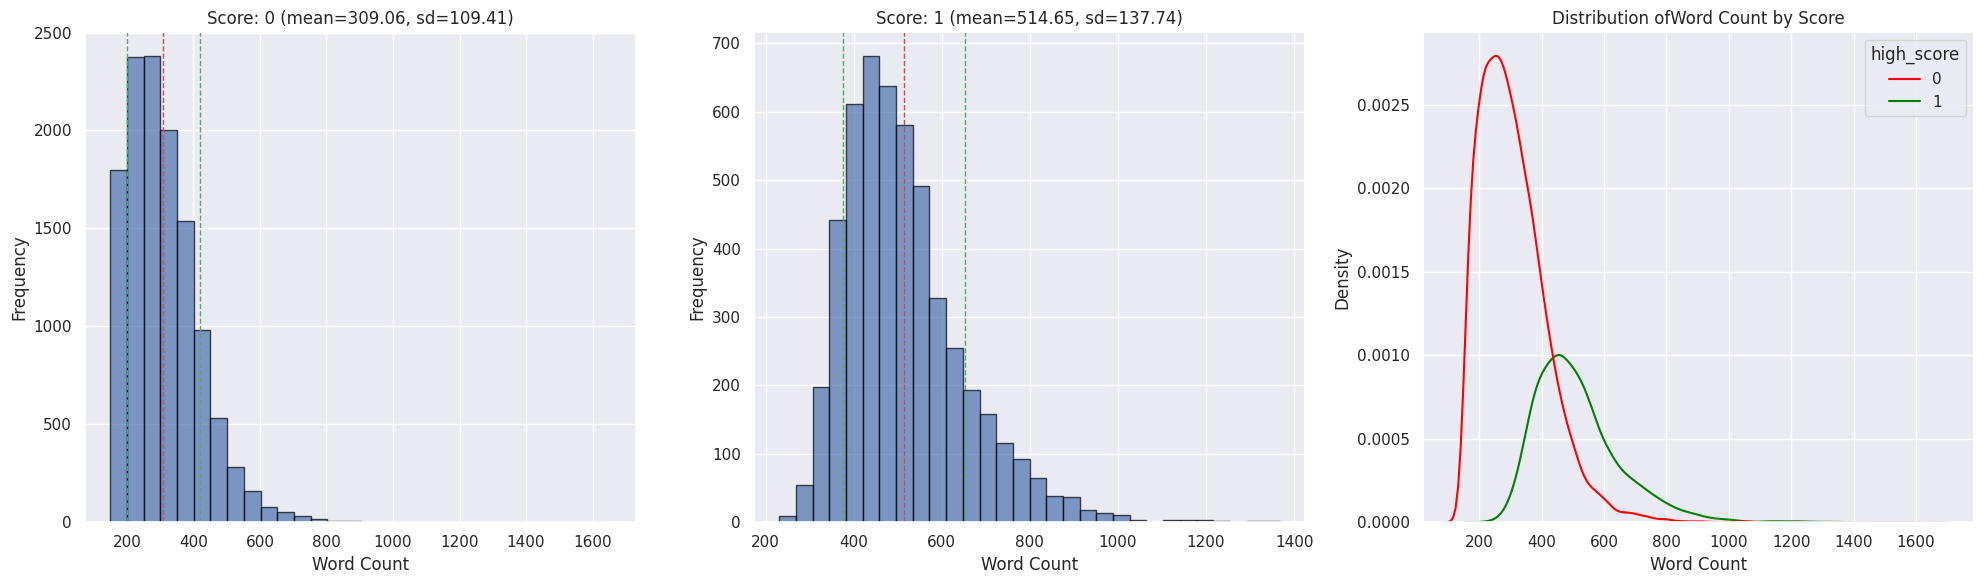

In [26]:
chart_high_score(data,'word_count', 'Word Count')

**Nhận xét:**

- Số lượng từ trung bình của nhóm điểm 1, 2, 3 nhỏ hơn số lượng từ trung bình của nhóm điểm 4, 5, 6.

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có số lượng từ
ít hơn các bài đạt điểm 4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng từ không ít hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng từ ít hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [27]:
accreditation(data, 'word_count', "greater")

t-statistic =  103.87481396488332
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Do đó, có thể nói rằng các bài luận thuộc nhóm high_score = 0 có số lượng từ ít hơn các bài luận thuộc nhóm high_score = 1

### **4. Số lượng câu**

In [28]:
def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

data['sentence_count'] = data['full_text'].apply(count_sentences)
data['sentence_count'].describe()

count    17307.000000
mean        19.231005
std          8.733818
min          1.000000
25%         13.000000
50%         18.000000
75%         24.000000
max        133.000000
Name: sentence_count, dtype: float64

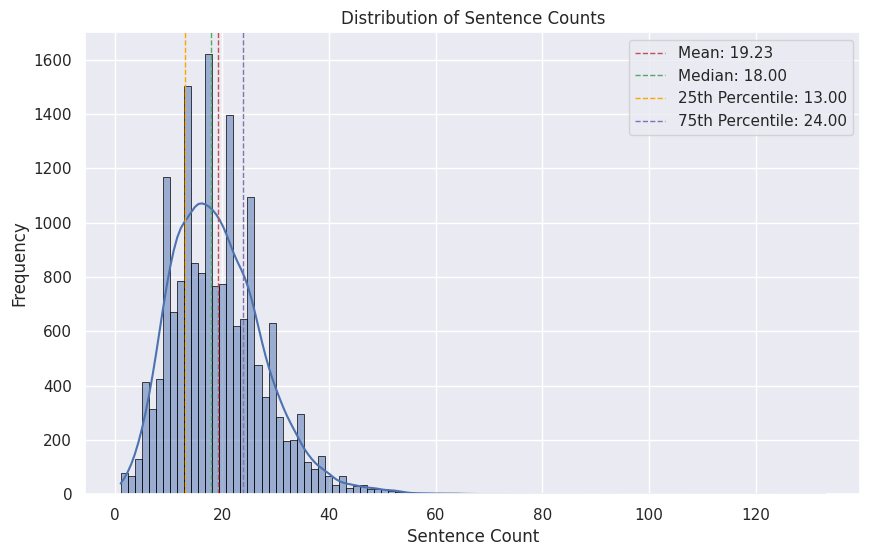

In [29]:
mean_val = data['sentence_count'].mean()
median_val = data['sentence_count'].median()
percentile_25 = np.percentile(data['sentence_count'], 25)
percentile_75 = np.percentile(data['sentence_count'], 75)

plt.figure(figsize=(10, 6))
sns.histplot(data['sentence_count'], bins=100, kde=True, edgecolor='black', color='b')
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='m', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Distribution of Sentence Counts')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('chart/sentence_count.svg')
plt.show()

**Nhận xét:**

- Đồ thị hơi lệch về phía dương vì **mean > median**, nhìn chung phân phối khá đều.
- Số lượng câu phổ biến nhất trong đoạn văn là 18 câu.
- Khoảng 75% số bài có số lượng câu ngắn, dưới 20 câu.
- Một số ít bài có số lượng câu dài trên 40 câu.

#### **Phân tích theo từng mức điểm**

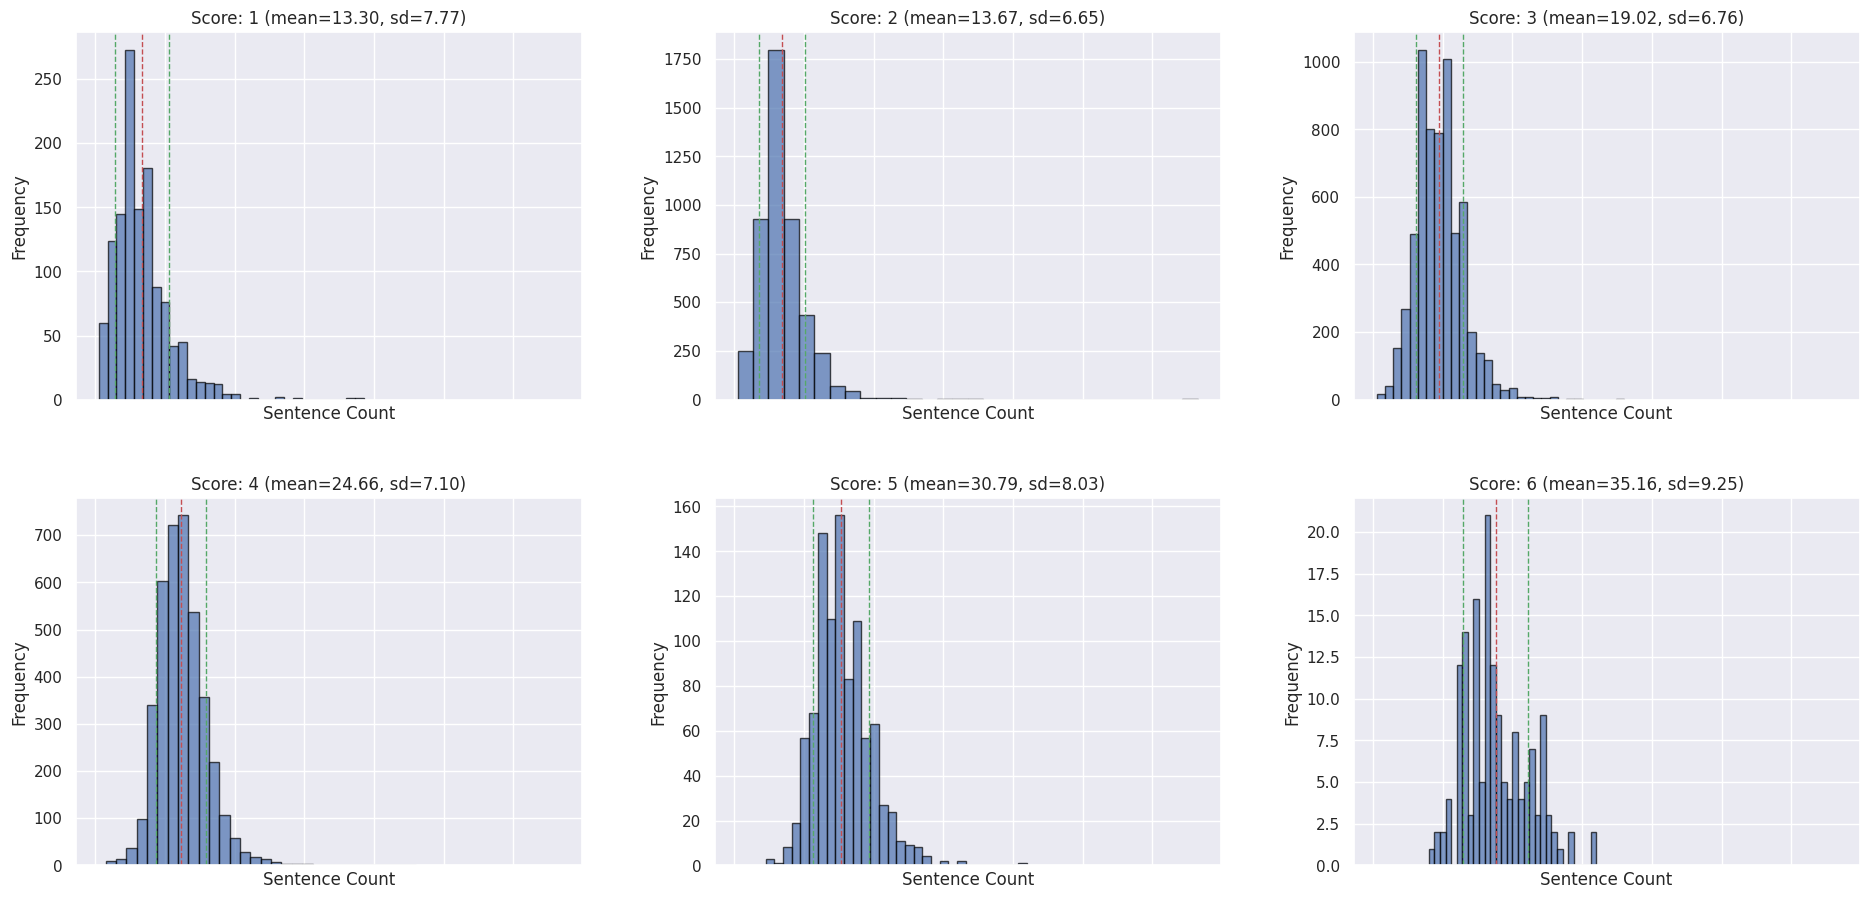

In [30]:
histogram_each_score(data, 'sentence_count', 'Sentence Count')

**Nhận xét:**

- Ta thấy số lượng câu trung bình của điểm 1, 2, 3 đều nhỏ hơn điểm 4, 5, 6.
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về số lượng câu của các bài văn.

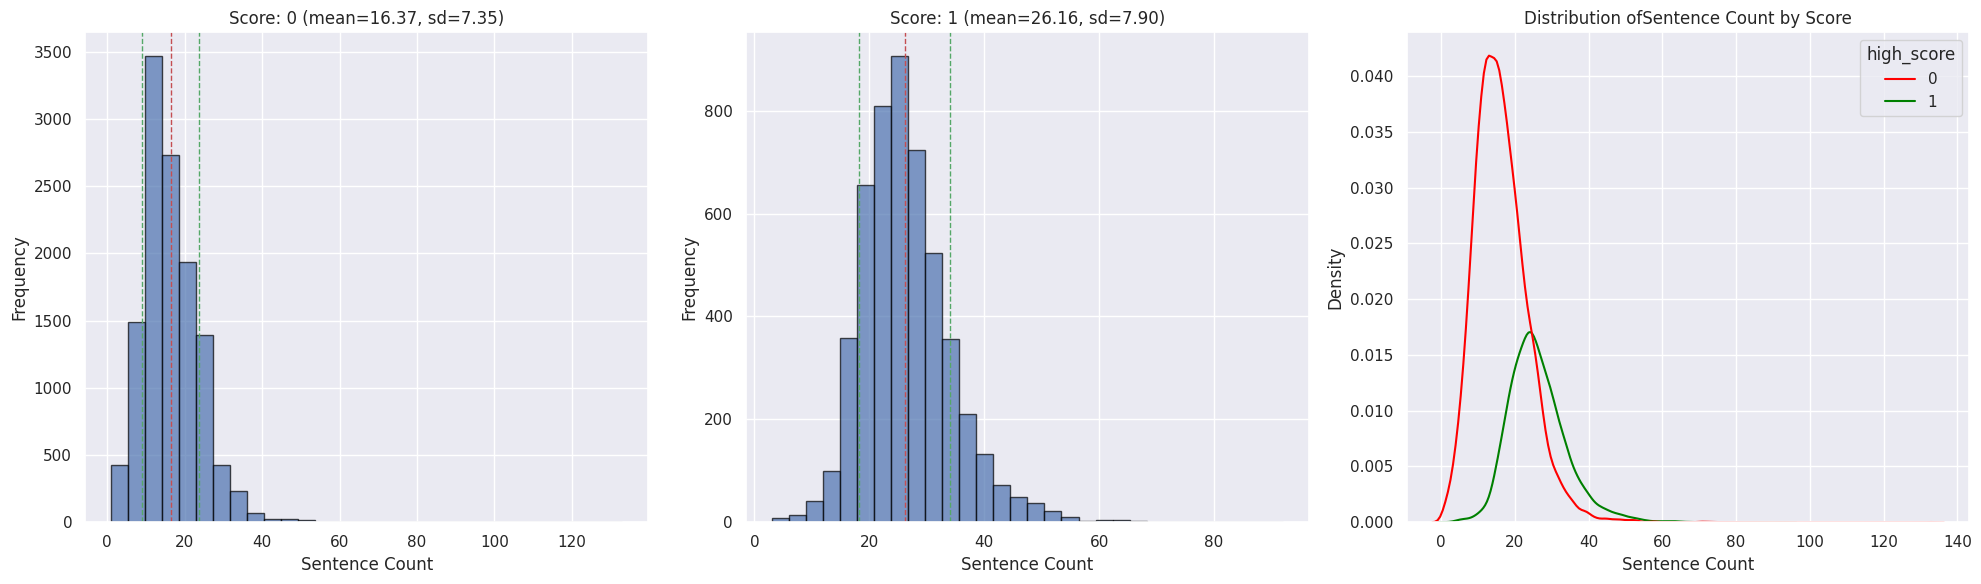

In [31]:
chart_high_score(data,'sentence_count', 'Sentence Count')

**Nhận xét:**
- Số lượng câu trung bình của nhóm điểm 1, 2, 3 nhỏ hơn số lượng câu trung bình của nhóm điểm 4, 5, 6

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có số lượng câu ít hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng câu không ít hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng câu ít hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [32]:
accreditation(data, 'sentence_count', "greater")

t-statistic =  77.86330069147428
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Có thể nói rằng các bài luận thuộc nhóm high_score = 0 có số lượng câu ít hơn các bài luận thuộc nhóm high_score = 1

### **5. Số lượng đoạn văn**

In [33]:
data['num_paragraphs'] = data['full_text'].apply(lambda x: (x.count('\n\n') + 1))
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  len_text  word_count  mean_word_length  sentence_count  \
0           0      2652         494          4.356275              13   
1           0      1670         335          3.976119              21   
2           1      3068         550          4.574545              24   
3           1      2686         448          4.977679              20   
4           0      2190         373          4.857909              15   

   num_paragraphs  
0               1  
1               5  
2               4  
3               5  
4               6

In [34]:
data['num_paragraphs'].describe()

count    17307.000000
mean         4.965274
std          3.311622
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max         66.000000
Name: num_paragraphs, dtype: float64

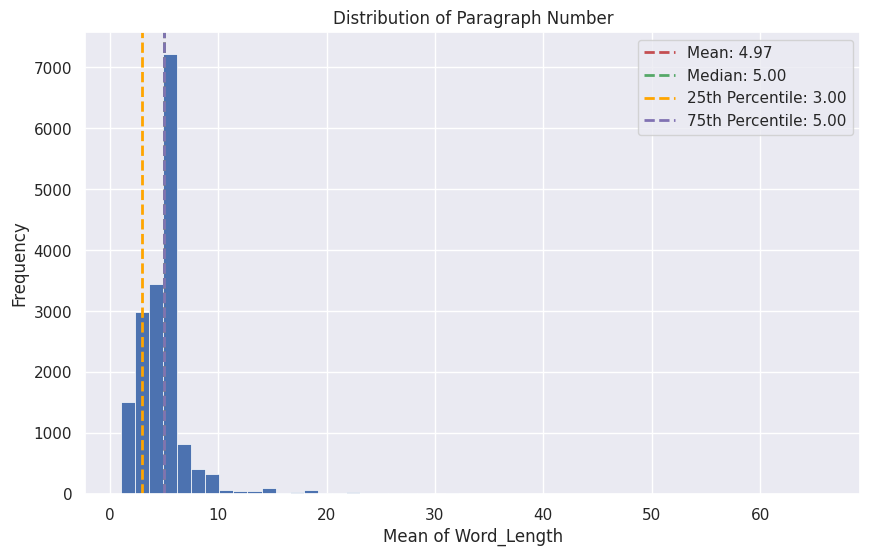

In [35]:
mean_val = data['num_paragraphs'].mean()
median_val = data['num_paragraphs'].median()
percentile_25 = np.percentile(data['num_paragraphs'], 25)
percentile_75 = np.percentile(data['num_paragraphs'], 75)

plt.figure(figsize=(10, 6))
plt.hist(data['num_paragraphs'], bins=50, edgecolor='w', linewidth=0.5)
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='m', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Distribution of Paragraph Number')
plt.xlabel('Mean of Word_Length')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('chart/Num_paragraph.svg')
plt.show()

#### **Phân tích theo từng mức điểm**

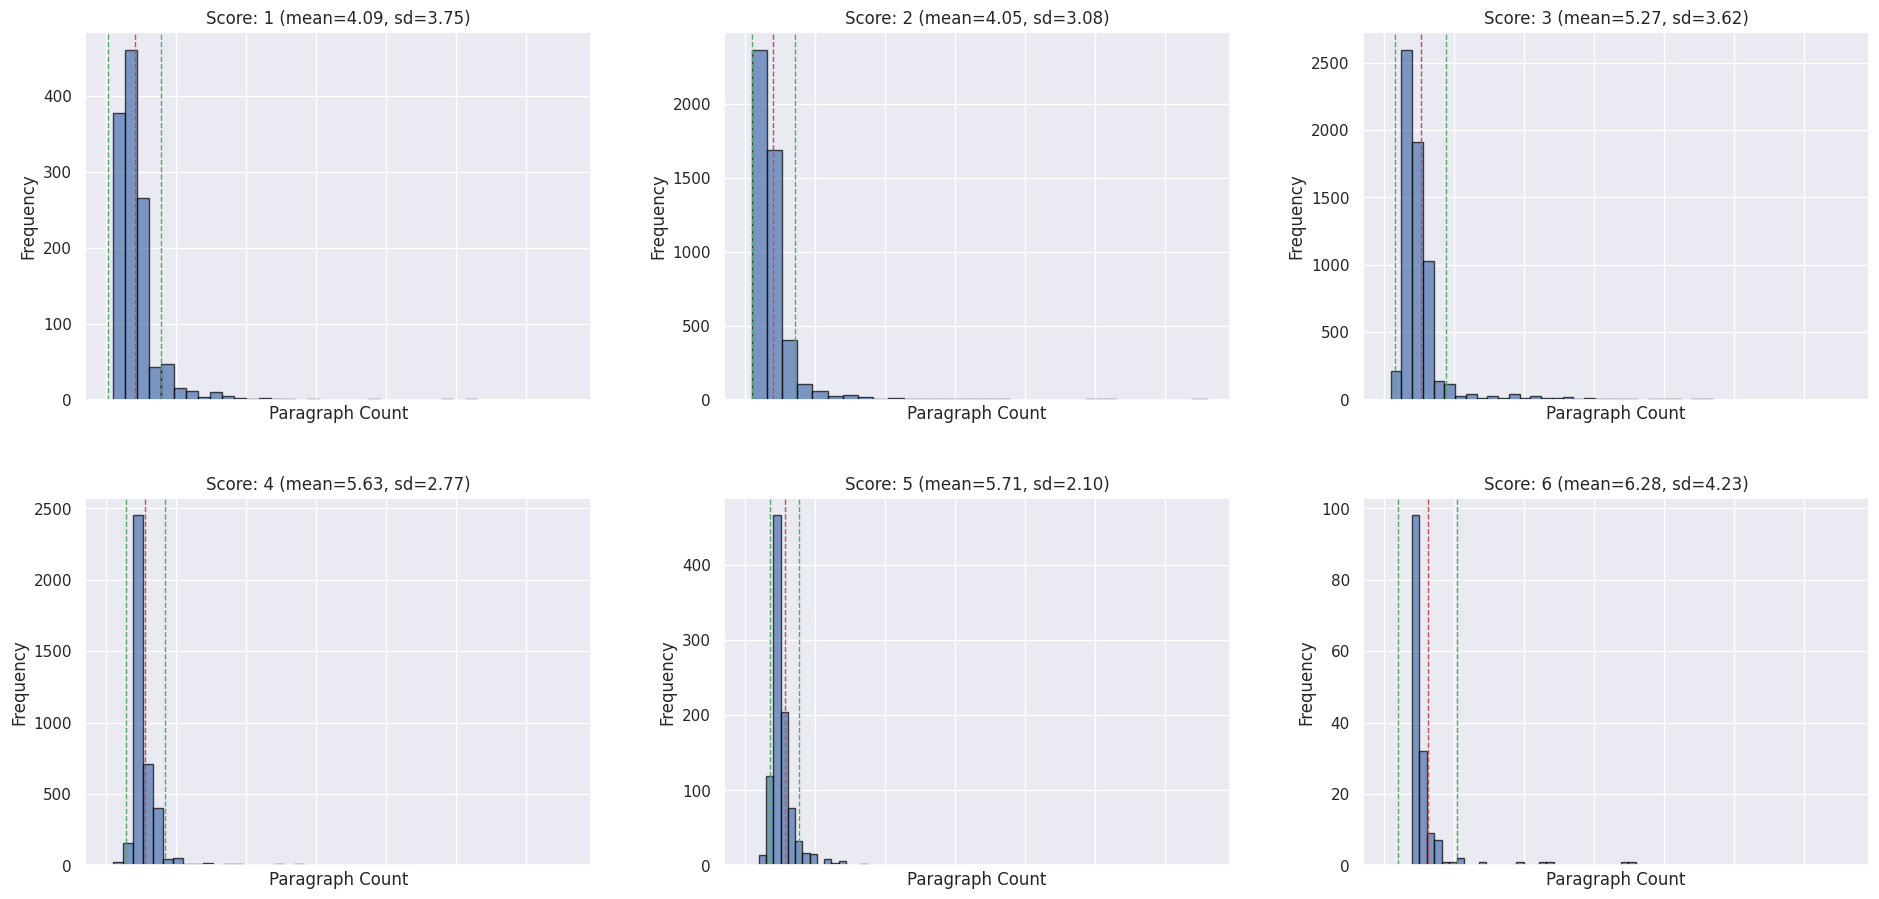

In [36]:
histogram_each_score(data, 'num_paragraphs', 'Paragraph Count')

**Nhận xét:**
- Ta thấy số lượng đoạn văn trung bình của điểm 1, 2, 3 đều nhỏ hơn điểm 4, 5, 6.
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về số lượng đoạn văn của các bài văn.

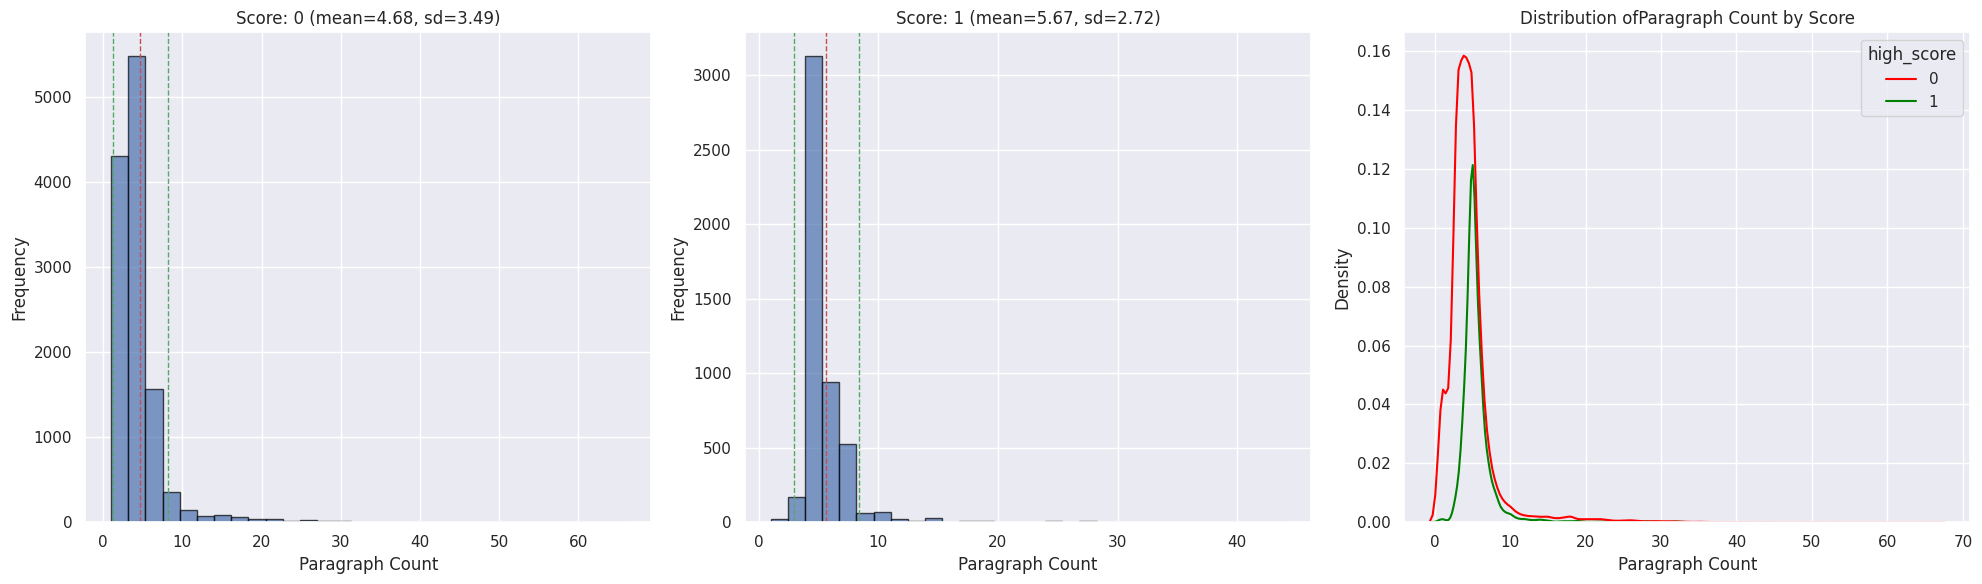

In [37]:
chart_high_score(data,'num_paragraphs', 'Paragraph Count')

**Nhận xét:**

- Số lượng đoạn văn trung bình của nhóm điểm 1, 2, 3 lớn nhỏ số lượng đoạn văn trung bình của nhóm điểm 4, 5, 6.
- Đa phần số lượng đoạn văn của nhóm điểm 1, 2, 3 nhỏ hơn hoặc bằng 5 đoạn trong khi nhóm điểm 4, 5, 6 lại chủ yếu là 5 đến nhỏ hơn 10 đoạn.

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có số lượng đoạn văn ít hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có số lượng đoạn văn không ít hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có số lượng đoạn văn ít hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [38]:
accreditation(data, 'num_paragraphs',"greater")

t-statistic =  18.067446869919287
p-value =  1.3275999057322046e-72
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Có thể nói rằng các bài luận thuộc nhóm high_score = 0 có số lượng đoạn văn ít hơn các bài luận thuộc nhóm high_score = 1

### **6. Tính cảm xúc**

In [39]:
from textblob import TextBlob
data['sentiment'] = data['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  len_text  word_count  mean_word_length  sentence_count  \
0           0      2652         494          4.356275              13   
1           0      1670         335          3.976119              21   
2           1      3068         550          4.574545              24   
3           1      2686         448          4.977679              20   
4           0      2190         373          4.857909              15   

   num_paragraphs  sentiment  
0               1   0.169343  
1               5   0.101786  
2               4   0.168435  
3               5   0.094291  
4               6   0.170952

In [40]:
data['sentiment'].describe()

count    17307.000000
mean         0.138620
std          0.100928
min         -0.365189
25%          0.075597
50%          0.133924
75%          0.195952
max          0.612500
Name: sentiment, dtype: float64

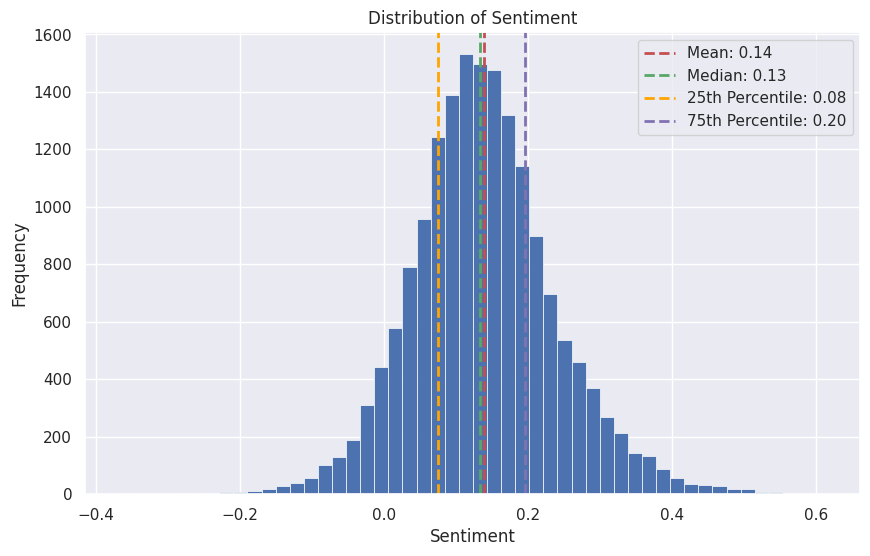

In [41]:
mean_val = data['sentiment'].mean()
median_val = data['sentiment'].median()
percentile_25 = np.percentile(data['sentiment'], 25)
percentile_75 = np.percentile(data['sentiment'], 75)

plt.figure(figsize=(10, 6))
plt.hist(data['sentiment'], bins=50, edgecolor='w', linewidth=0.5)
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='m', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('chart/Sentiment.svg')
plt.show()

#### **Phân tích theo từng mức điểm**

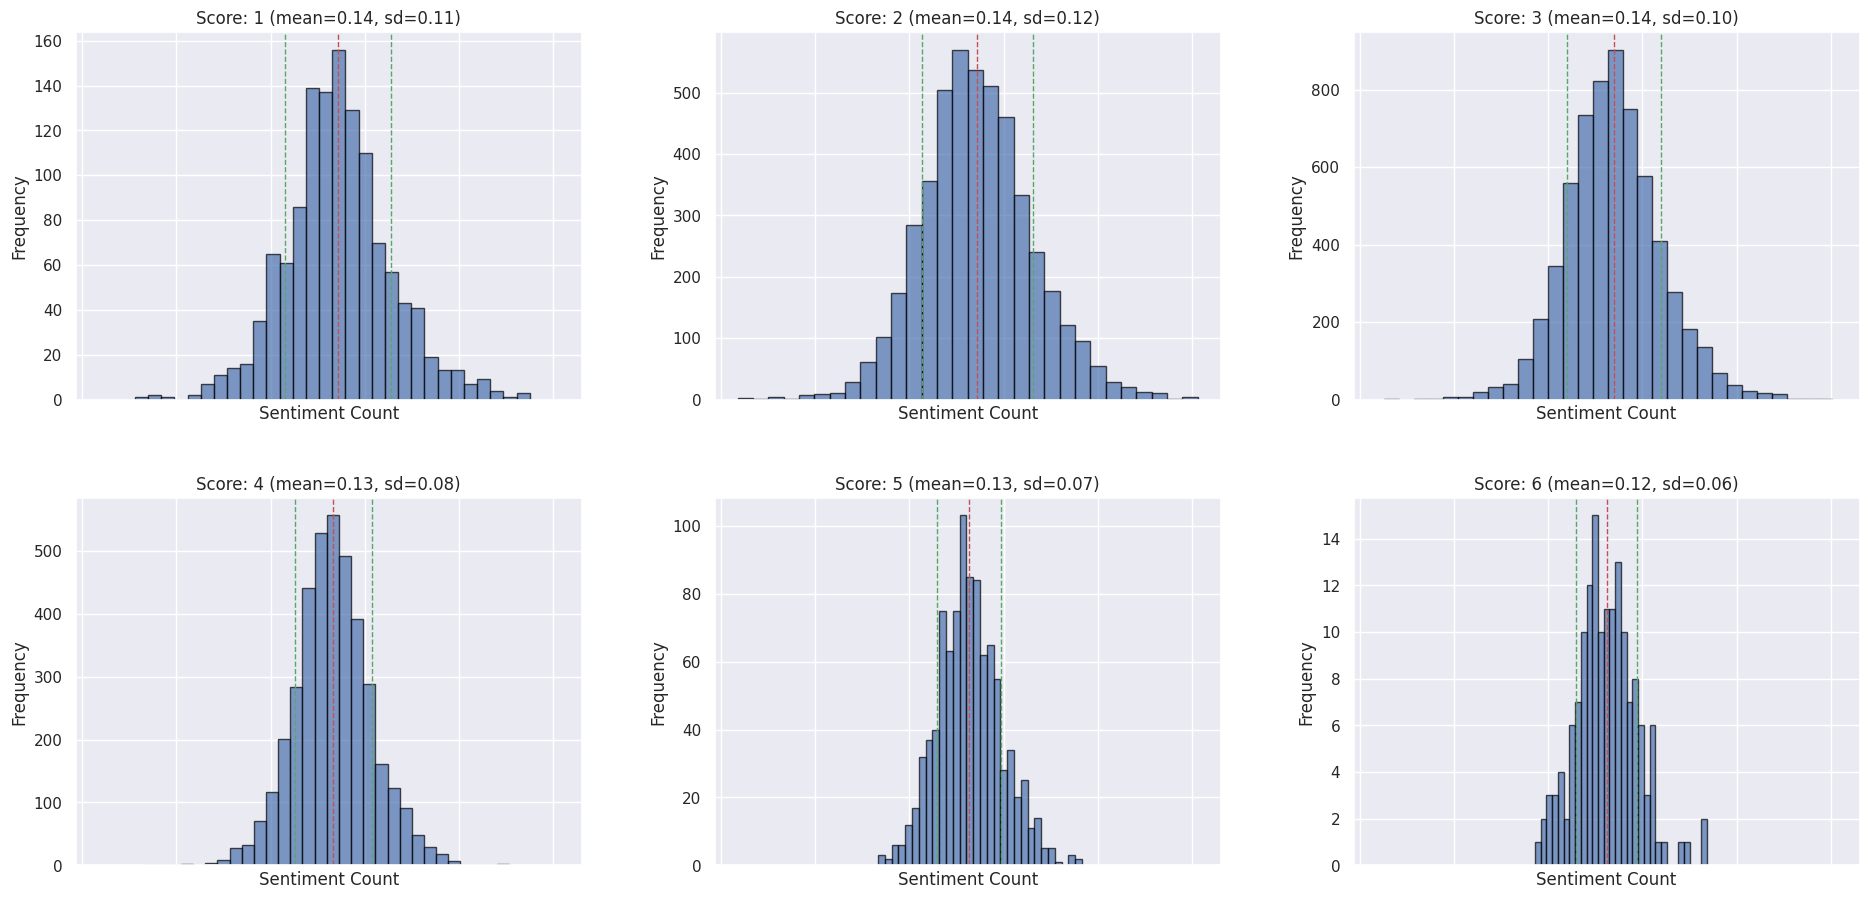

In [42]:
histogram_each_score(data, 'sentiment', 'Sentiment Count')

**Nhận xét**
- Giá trị độ cảm xúc trung bình của các bài đạt điểm 4, 5, 6 đều bằng nhau là 0.13.
- Vì vậy, ta có thể sử dụng cột `high_score` để khám phá tiếp về độ cảm xúc của các bài văn.

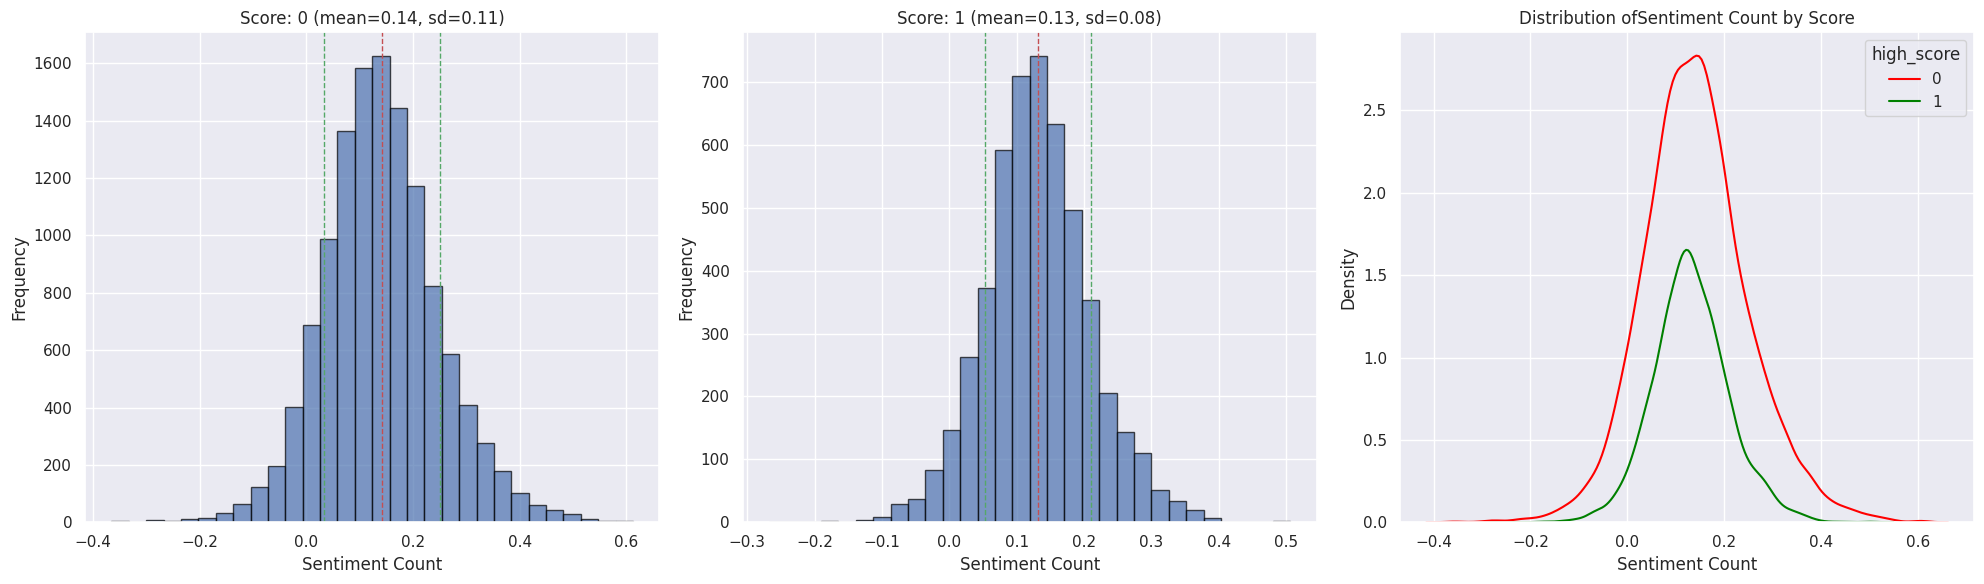

In [43]:
chart_high_score(data,'sentiment', 'Sentiment Count')

**Nhận xét:**

- Giá trị độ cảm xúc trung bình của nhóm điểm 1, 2, 3 lớn hơn giá trị độ cảm xúc trung bình của nhóm điểm 4, 5, 6

Ta không biết được rằng liệu các bài viết đạt điểm 1,2,3 sẽ có giá trị độ cảm xúc nhiều hơn các bài đạt điểm  4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có giá trị độ cảm xúc không nhiều hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có giá trị độ cảm xúc nhiều hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [44]:
accreditation(data, 'sentiment',"greater")

t-statistic =  -5.852576841314484
p-value =  0.9999999975362079
Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa 0.05


Có thể nói rằng các bài luận thuộc nhóm high_score = 0 có tính cảm xúc không nhiều hơn các bài luận thuộc nhóm high_score = 1

### **7. Tính chủ quan**

In [45]:
data['subjectivity'] = data['full_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  len_text  word_count  mean_word_length  sentence_count  \
0           0      2652         494          4.356275              13   
1           0      1670         335          3.976119              21   
2           1      3068         550          4.574545              24   
3           1      2686         448          4.977679              20   
4           0      2190         373          4.857909              15   

   num_paragraphs  sentiment  subjectivity  
0               1   0.169343      0.542236  
1               5   0.101786      0.444643  
2               4   0.168435      0.451264  
3               5   0.094291      0.555147  
4               6   0.170952      0.569127

In [46]:
data['subjectivity'].describe()

count    17307.000000
mean         0.490727
std          0.084745
min          0.000000
25%          0.435351
50%          0.488636
75%          0.544139
max          0.913889
Name: subjectivity, dtype: float64

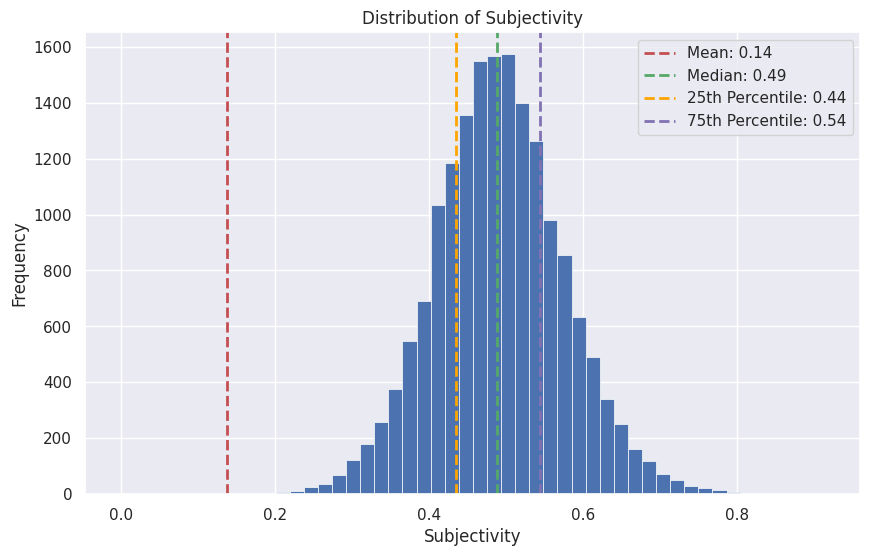

In [47]:
pmean_val = data['subjectivity'].mean()
median_val = data['subjectivity'].median()
percentile_25 = np.percentile(data['subjectivity'], 25)
percentile_75 = np.percentile(data['subjectivity'], 75)

plt.figure(figsize=(10, 6))
plt.hist(data['subjectivity'], bins=50, edgecolor='w', linewidth=0.5)
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='m', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Distribution of Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('chart/Subjectivity.svg')
plt.show()

#### **Phân tích theo từng mức điểm**

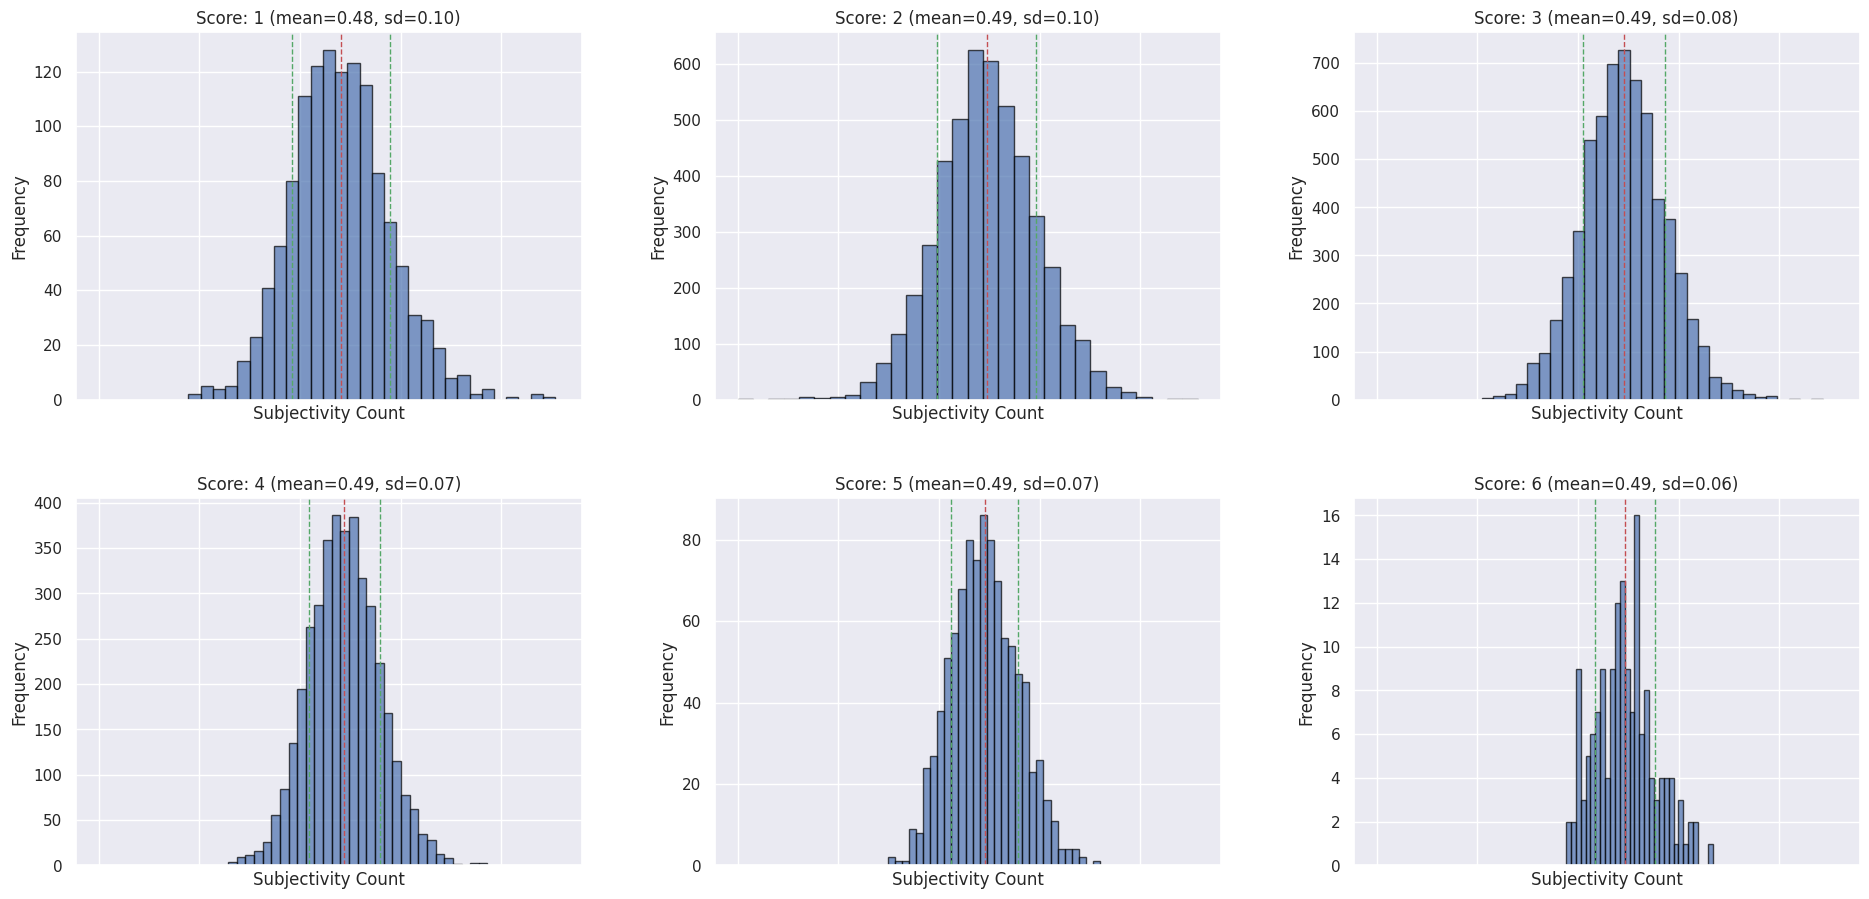

In [48]:
histogram_each_score(data, 'subjectivity', 'Subjectivity Count')

**Nhận xét:**
- Giá trị độ tính chủ quan trung bình của các bài đạt điểm 2, 3, 4, 5, 6 đều bằng nhau là 0.49.
- Độ lệch chuẩn của nhóm high_score = 0 lớn hơn nhóm high_score = 1.

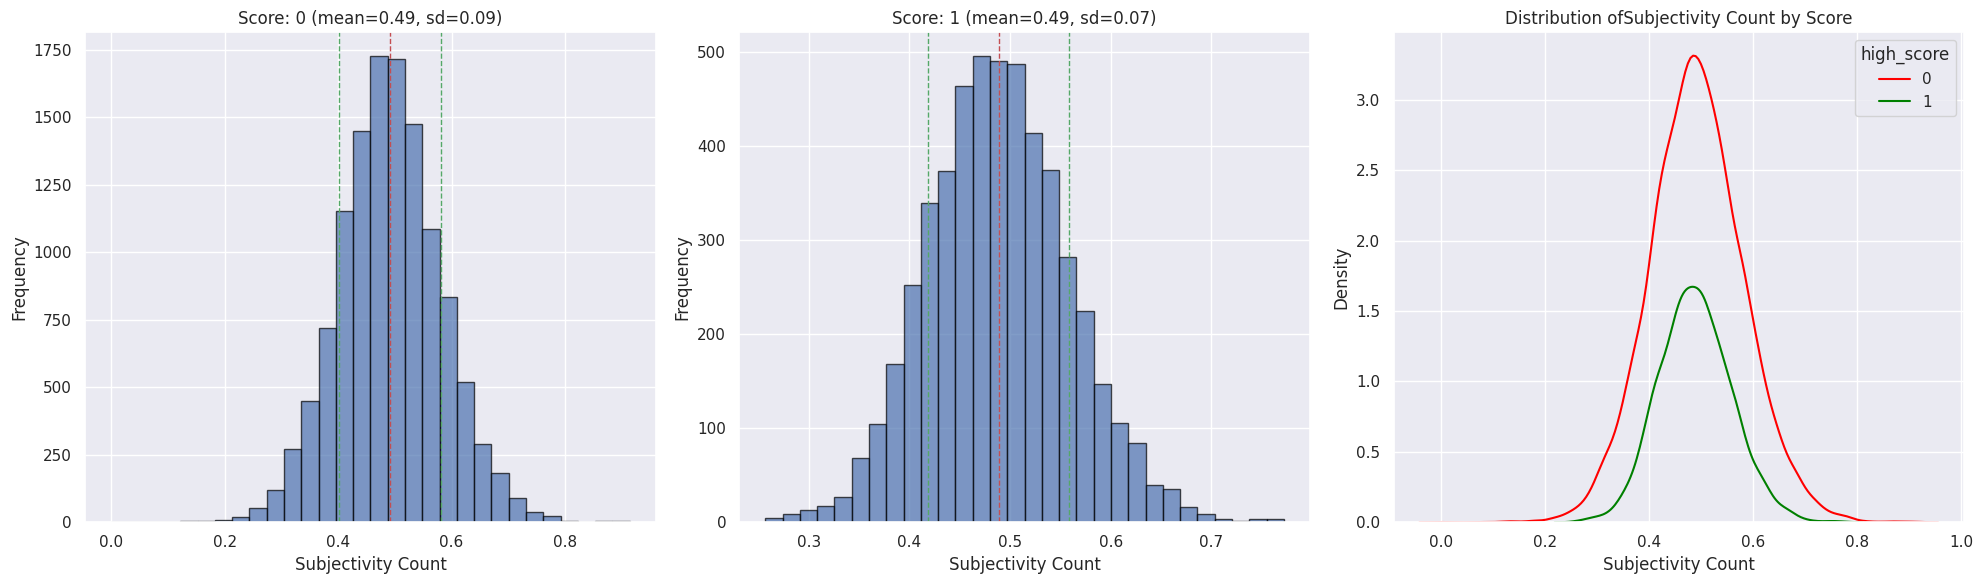

In [49]:
chart_high_score(data,'subjectivity', 'Subjectivity Count')

**Nhận xét:**
- Giá trị độ chủ quan trung bình của nhóm điểm 1, 2, 3 bằng với độ chủ quan trung bình của nhóm điểm 4, 5, 6
- Tuy nhiên, về mặt phân phối thì độ chủ quan trung bình của nhóm điểm 1, 2, 3 lại cao hơn độ chủ quan trung bình của nhóm điểm 4, 5, 6

Các bài viết đạt điểm 1, 2, 3 sẽ có tính chủ quan trung bình bằng các bài
đạt điểm 4, 5 và 6 hay không. Ta sẽ sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có tính chủ quan không bằng các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có tính chủ quan bằng các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [50]:
accreditation(data, 'subjectivity', "two-sided")

t-statistic =  -2.122803294063824
p-value =  0.03378449561845223
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Có thể nói rằng các bài luận thuộc nhóm high_score = 0 có tính chủ quan bằng các bài luận thuộc nhóm high_score = 1

### **8. Tính đa dạng từ vựng**


In [51]:
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words)

data['lexical_diversity'] = data['full_text'].apply(lexical_diversity)
data.head()

essay_id                                          full_text  score  \
0  000d118  many people have car where they live. the thin...      3   
1  000fe60  i am a scientist at nasa that is discussing th...      3   
2  001ab80  people always wish they had the same technolog...      4   
3  001bdc0  we all heard about venus, the planet without a...      4   
4  002ba53  dear, state senator\n\nthis is a letter to arg...      3   

   high_score  len_text  word_count  mean_word_length  sentence_count  \
0           0      2652         494          4.356275              13   
1           0      1670         335          3.976119              21   
2           1      3068         550          4.574545              24   
3           1      2686         448          4.977679              20   
4           0      2190         373          4.857909              15   

   num_paragraphs  sentiment  subjectivity  lexical_diversity  
0               1   0.169343      0.542236           0.473684  
1               5   0.101786      0.444643           0.480597  
2               4   0.168435      0.451264           0.438182  
3               5   0.094291      0.555147           0.529018  
4               6   0.170952      0.569127           0.418231

In [52]:
data['lexical_diversity'].describe()

count    17307.000000
mean         0.506331
std          0.073388
min          0.054952
25%          0.454914
50%          0.503968
75%          0.555556
max          0.762500
Name: lexical_diversity, dtype: float64

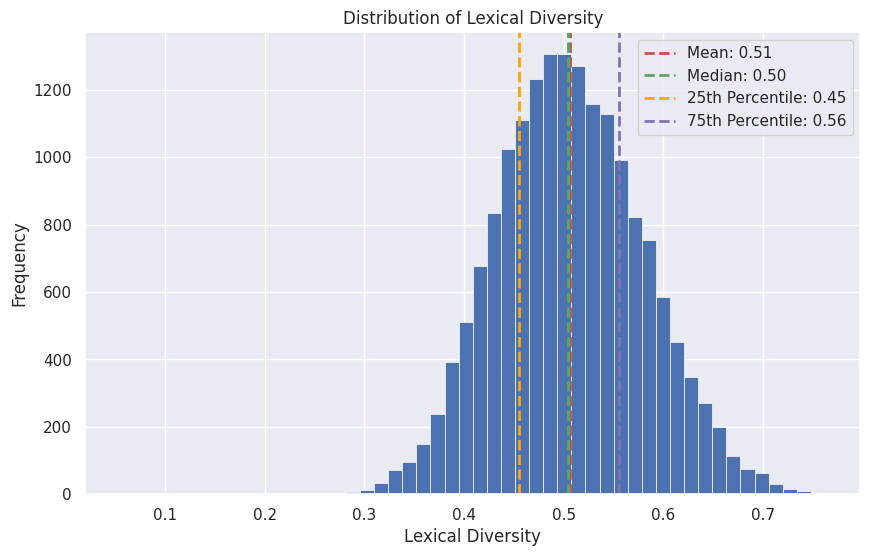

In [53]:
mean_val = data['lexical_diversity'].mean()
median_val = data['lexical_diversity'].median()
percentile_25 = np.percentile(data['lexical_diversity'], 25)
percentile_75 = np.percentile(data['lexical_diversity'], 75)

plt.figure(figsize=(10, 6))
plt.hist(data['lexical_diversity'], bins=50, edgecolor='w', linewidth=0.5)
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='m', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
plt.title('Distribution of Lexical Diversity')
plt.xlabel('Lexical Diversity')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('chart/Lexical_diversity.svg')
plt.show()

#### **Phân tích theo từng mức điểm**

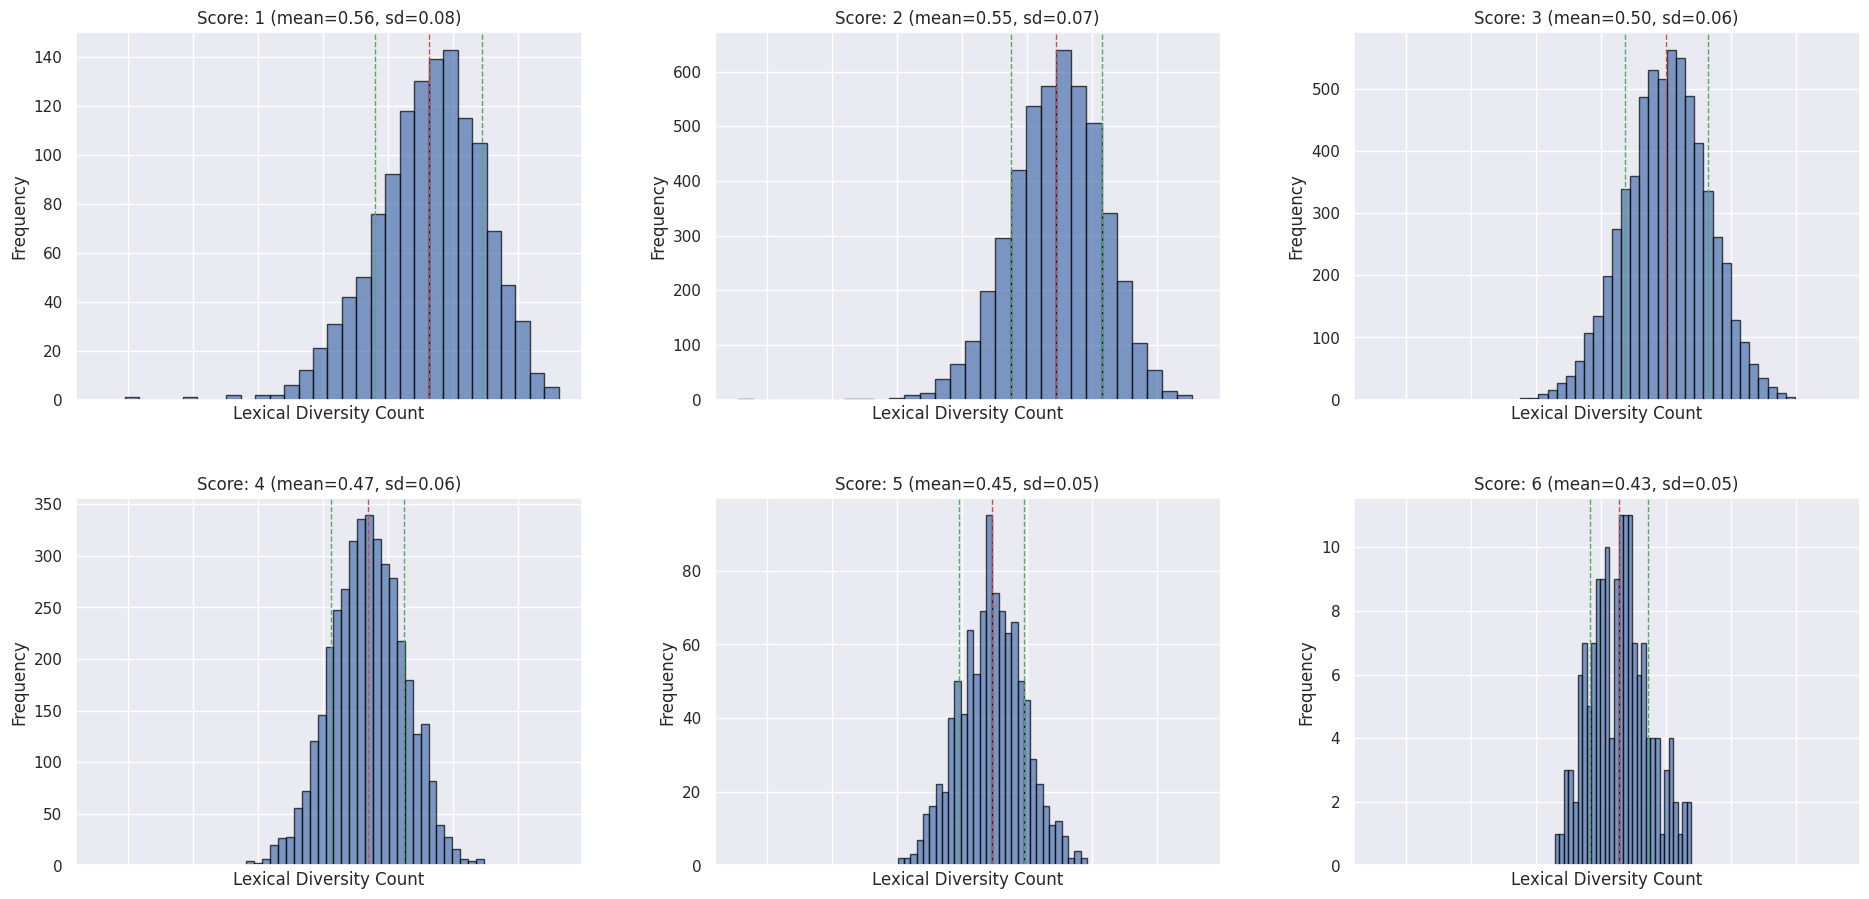

In [54]:
histogram_each_score(data, 'lexical_diversity', 'Lexical Diversity Count')

**Nhận xét:**
- Ta thấy ính đa dạng từ vựng trung bình của điểm 1, 2, 3 đều lớn hơn điểm 4, 5, 6.
- Do đó, ta sẽ sử dụng tiếp cột `high_score` để khám phá tiếp về tính đa dạng từ vựng của các bài văn.


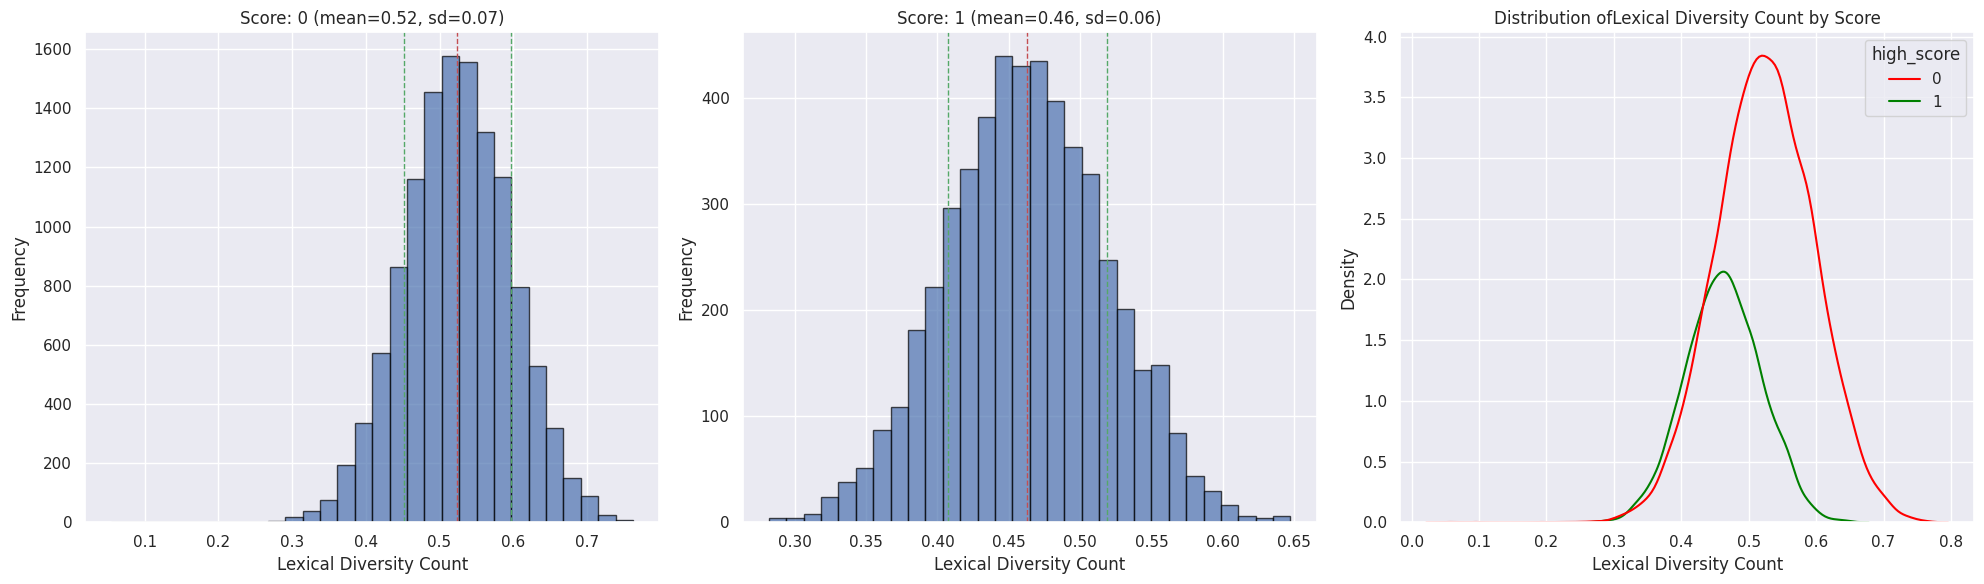

In [55]:
chart_high_score(data,'lexical_diversity', 'Lexical Diversity Count')

**Nhận xét:**
- Tính đa dạng từ vựng trung bình của nhóm điểm 1, 2, 3 lớn hơn Tính đa dạng từ vựng trung bình của nhóm điểm 4, 5, 6.
- Và về mặt phân phối thì điều này vẫn đúng.

Tuy nhiên, ta vẫn tiến hành sử dụng cột `high_score` đã tạo trước đó để tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các bài luận với giá trị high_score = 0 có tính đa dạng từ vựng không nhiều hơn các bài luận với giá trị high_score = 1"} \\
H_1: \text{"Các bài luận với giá trị high_score = 0 có tính đa dạng từ vựng nhiều hơn các bài luận với giá trị high_score = 1"}
\end{cases}

Với mức ý nghĩa $\alpha$:
- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.
- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [56]:
accreditation(data, 'lexical_diversity', "less")

t-statistic =  -54.04743821990564
p-value =  0.0
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Do đó, có thể nói rằng các bài luận thuộc nhóm high_score = 0 có tính đa dạng từ vựng nhiều hơn các bài luận thuộc nhóm high_score = 1

### **9. Tương quan giữa các thuộc tính**

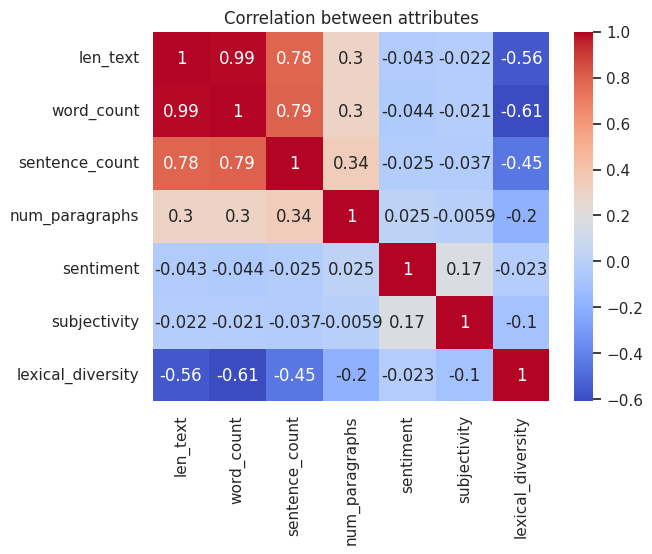

In [57]:
col = ['len_text', 'word_count', 'sentence_count', 'num_paragraphs', 'sentiment', 'subjectivity', 'lexical_diversity']
sns.heatmap(data[col].corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation between attributes')
# plt.savefig('chart/correlation.svg')
plt.show()

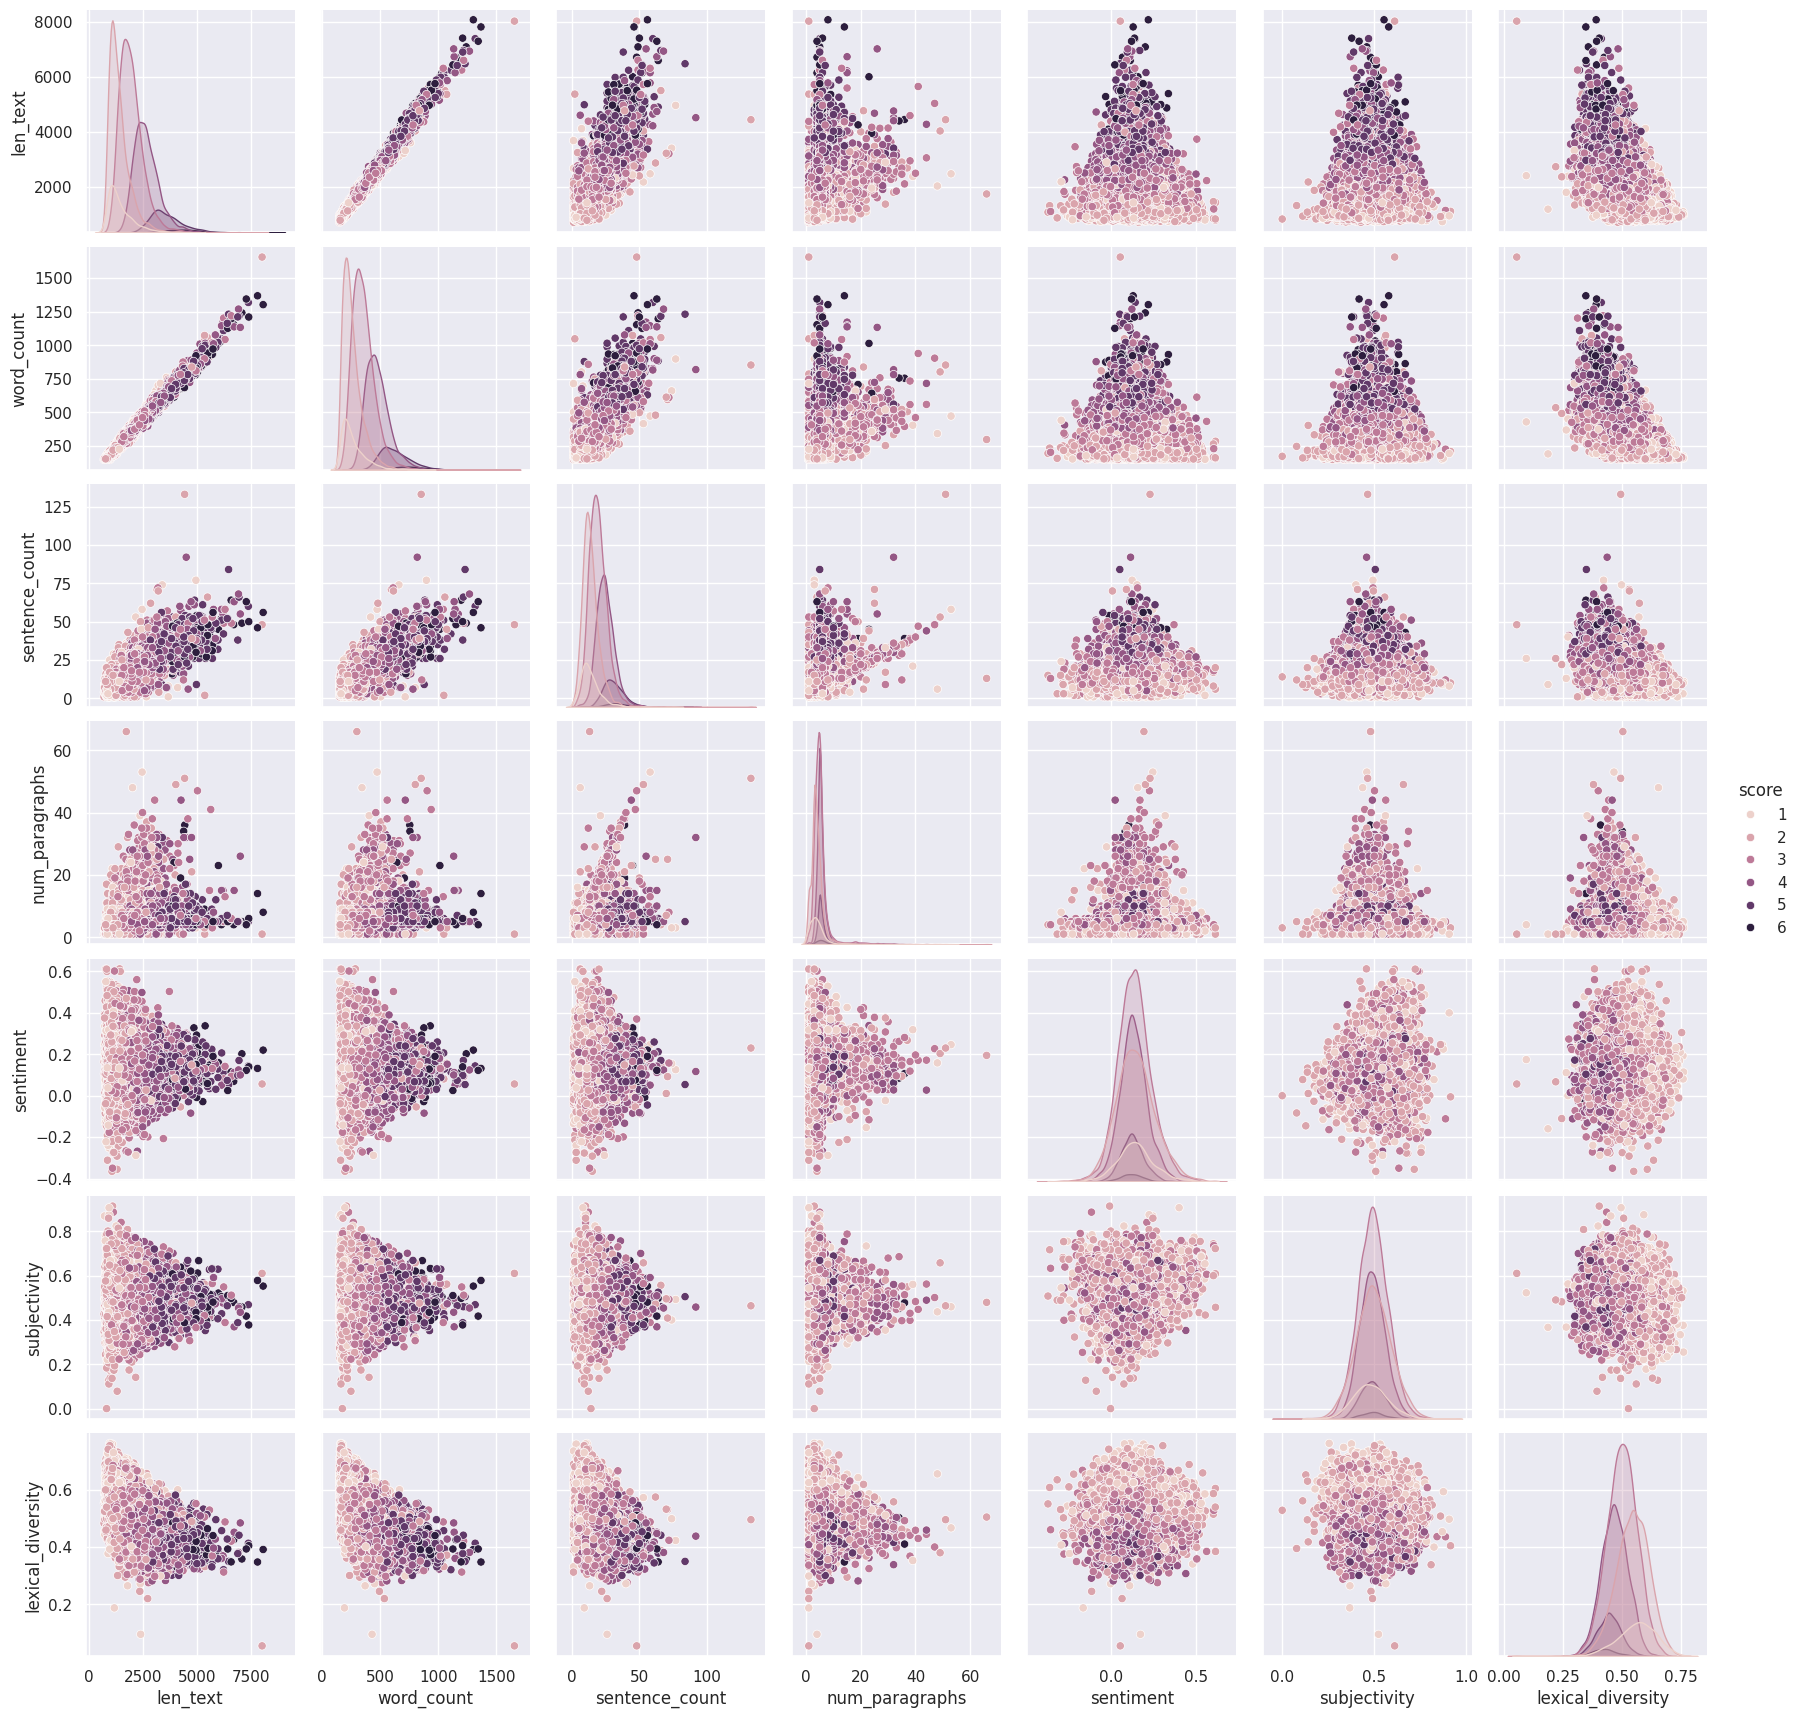

In [58]:
col = ['len_text', 'word_count', 'sentence_count', 'num_paragraphs', 'sentiment', 'subjectivity', 'lexical_diversity', 'score']
sns.pairplot(data[col], hue = 'score')
plt.show()
# plt.savefig('chart/pairplot.svg')

**Nhận xét:**

- Cột `len_text` và cột `word_count` có độ tương quan rất cao, cho thấy khi độ dài đoạn essay tăng thì số lượng từ sẽ tăng.
⇒ Có thể loại bỏ 1 trong hai cột này khi xây dựng model để tránh hiện tượng đa cộng tuyến.
- Tương quan giữa cột `sentence_count` - `len_text`, `sentence_count` - `word_count`,  `lexical_diversity` - `len_text`, `lexical_diversity` - `word_count` và `len_text` - `sentence_count` có độ tương quan trung bình.
- Các cặp còn lại hầu như có độ tương quan khá thấp.

### **10. Phân tích stopword và n-grams**

*   Ta sẽ so sánh giữa các mô hình N-gram trước và sau khi lọc các stop word
*   List item



#### **Unigram**

In [59]:
#  Unigram - Tan so 1 tu khi chua loc stop word
texts = data['full_text']
vec = CountVectorizer(ngram_range=(1,1)).fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
top_20_words = pd.DataFrame(words_freq[:20], columns=['word', 'freq'])

#  Unigram - Tan so 1 tu khi da loc stop word
vec_sw = CountVectorizer(ngram_range=(1,1), stop_words = 'english').fit(texts)
bag_of_words_sw = vec_sw.transform(texts)
sum_words_sw = bag_of_words_sw.sum(axis=0)
words_freq_sw = [(word, sum_words_sw[0, idx]) for word, idx in vec_sw.vocabulary_.items()]
words_freq_sw = sorted(words_freq_sw, key = lambda x: x[1], reverse=True)
top_20_words_sw = pd.DataFrame(words_freq_sw[:20], columns=['word', 'freq'])

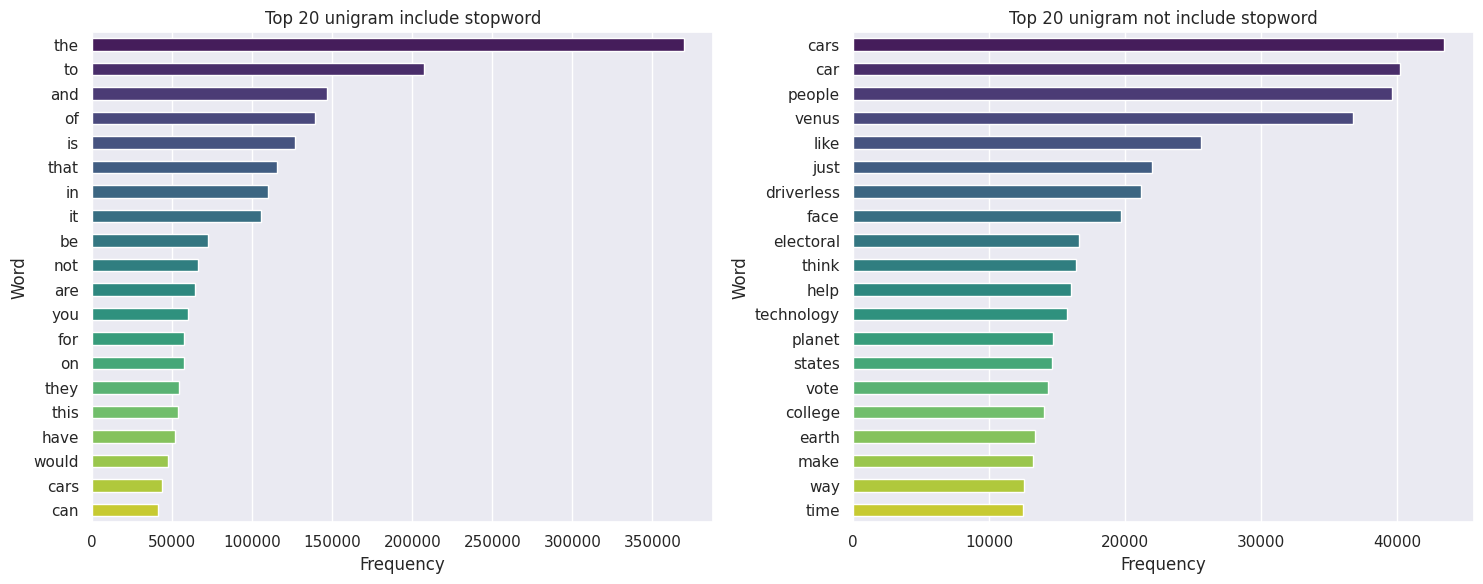

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='freq', y='word', data=top_20_words, orient='h', ax=ax[0], width=0.5, palette='viridis')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Word')
ax[0].set_title('Top 20 unigram include stopword')

sns.barplot(x='freq', y='word', data=top_20_words_sw, orient='h', ax=ax[1], width=0.5, palette='viridis')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Word')
ax[1].set_title('Top 20 unigram not include stopword')

plt.tight_layout()
# plt.savefig('chart/1gram.svg')
plt.show()

**Nhận xét:**

- Stopword chiếm số lượng khác lớn trong đoạn văn.
- Stopword được dùng nhiều nhất là '**the**', lên đến 350000 lần, gấp 10 lần '**cars**' (từ có số lần xuất hiện nhiều nhất sau khi loại bỏ stopword)
- Biểu đồ unigram có sự khác biệt lớn sau khi loại bỏ các stopword.
- Từ biểu đồ bên dưới có thể nhận thấy phần lớn nội dung essay có lẽ là về **car** vì các từ được dùng nhiều nhất đều có liên quan đến xe.

**Ta sẽ tìm hiểu sâu hơn về từng mức điểm của bài luận (khi đã loại bỏ những stopwords)**


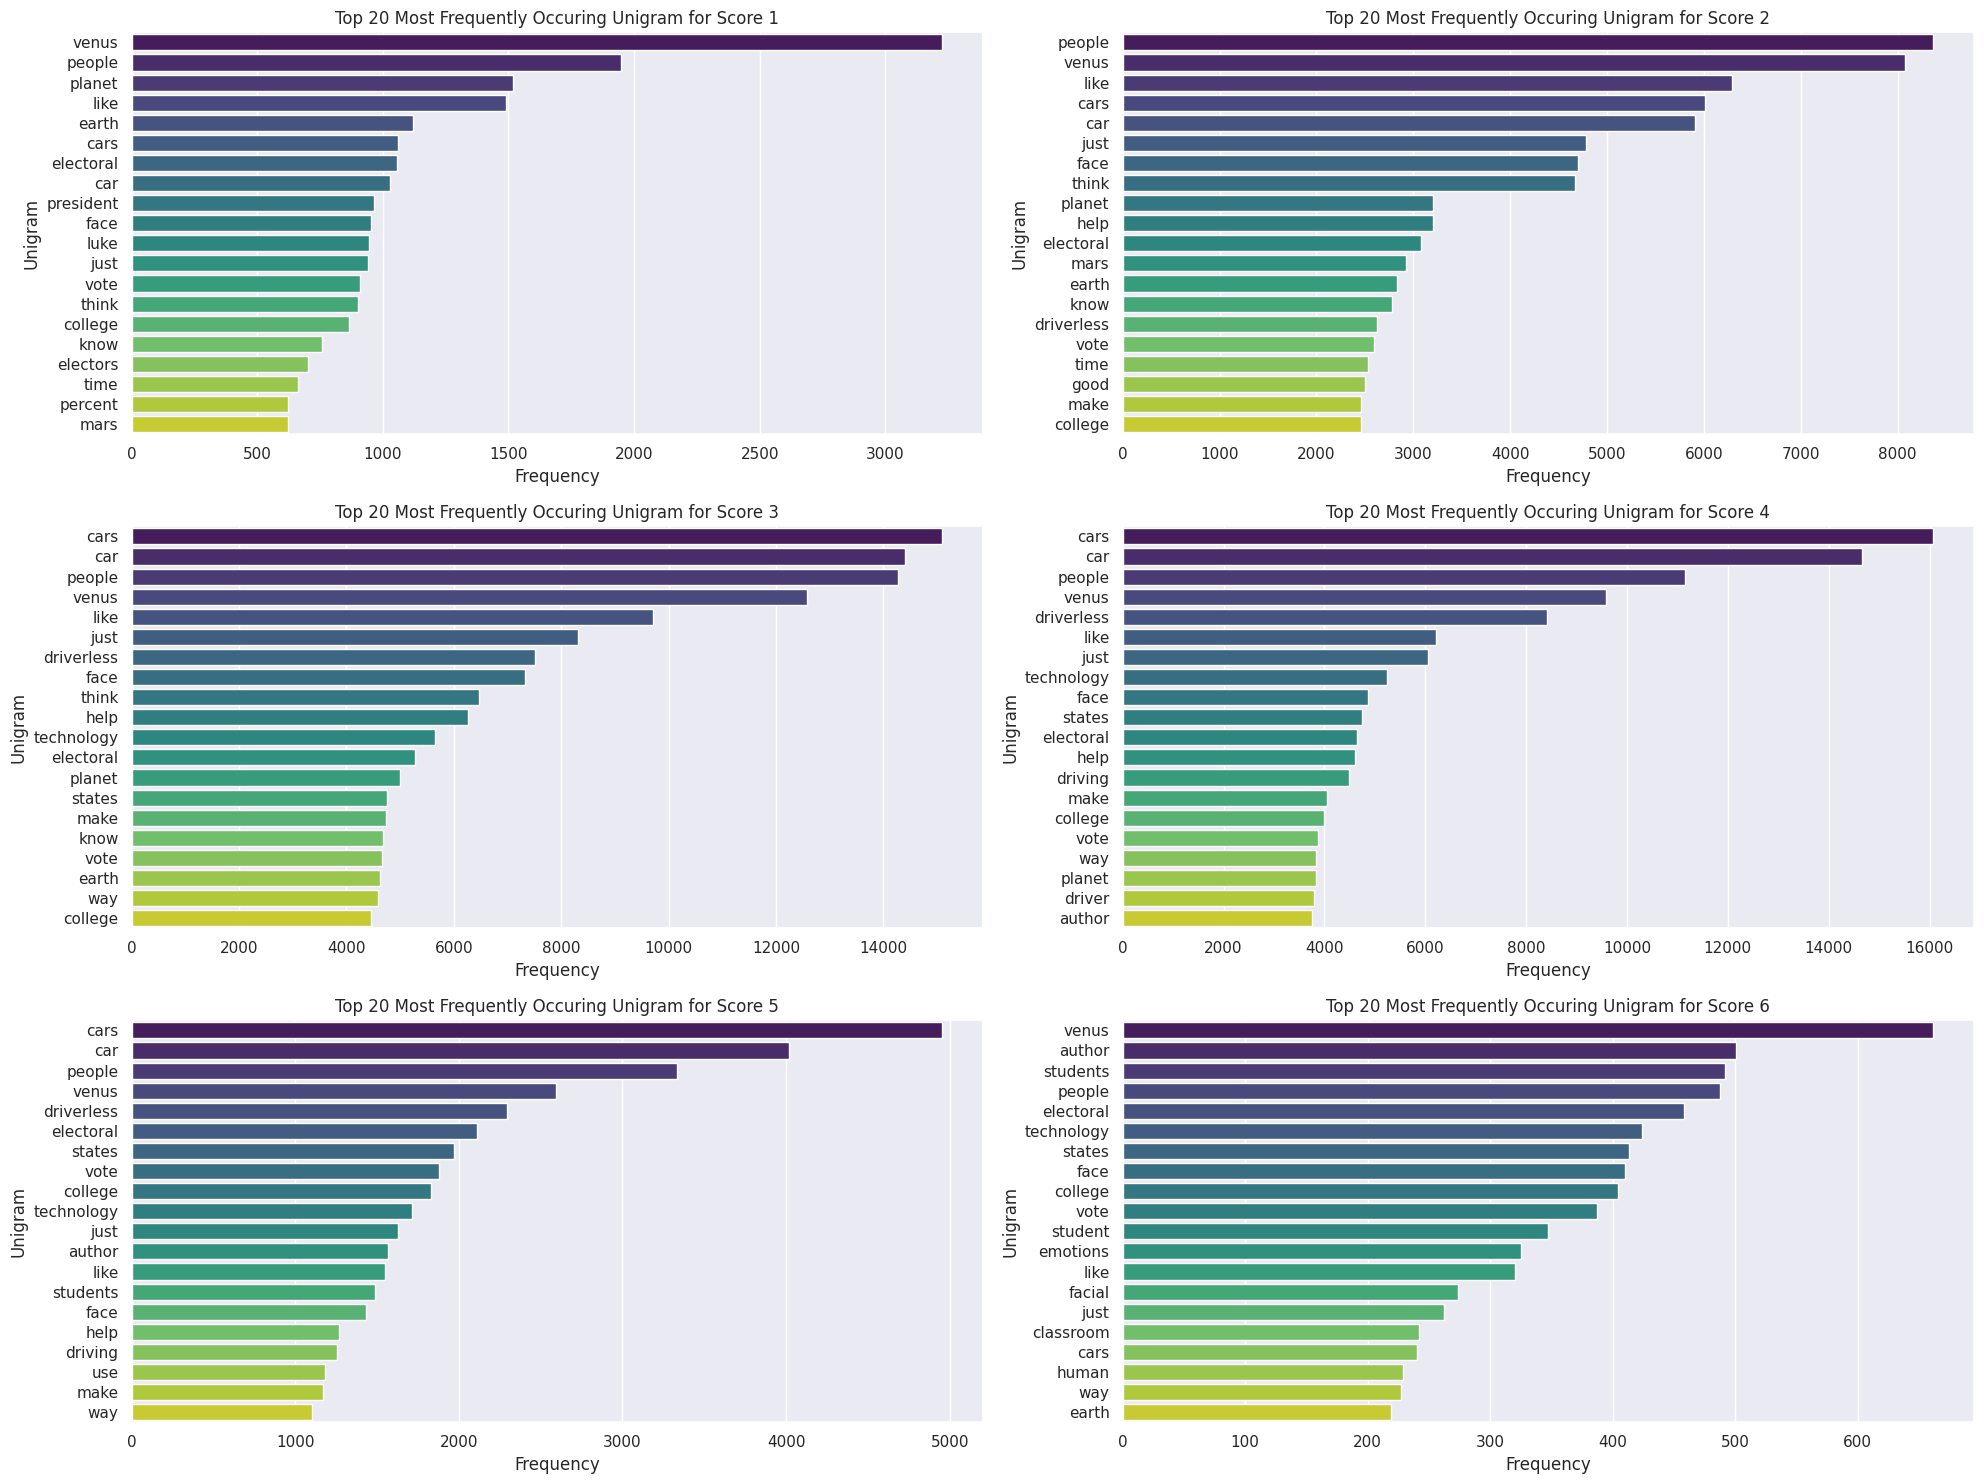

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axes = axes.flatten()

for score in range(1, 7):
    score_texts = data[data['score'] == score]['full_text']
    vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words = 'english')
    X = vectorizer.fit_transform(score_texts)

    sum_unigram = X.sum(axis=0)
    unigram_freq = [(word, sum_unigram[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    unigram_freq = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

    unigram_df = pd.DataFrame(unigram_freq, columns=['unigram', 'frequency'])

    sns.barplot(x='frequency', y='unigram', data=unigram_df.head(20), ax=axes[score-1], palette='viridis')
    axes[score-1].set_title(f'Top 20 Most Frequently Occuring Unigram for Score {score}')
    axes[score-1].set_xlabel('Frequency')
    axes[score-1].set_ylabel('Unigram')

plt.tight_layout()
# plt.savefig('chart/1gram_score.svg')
plt.show()

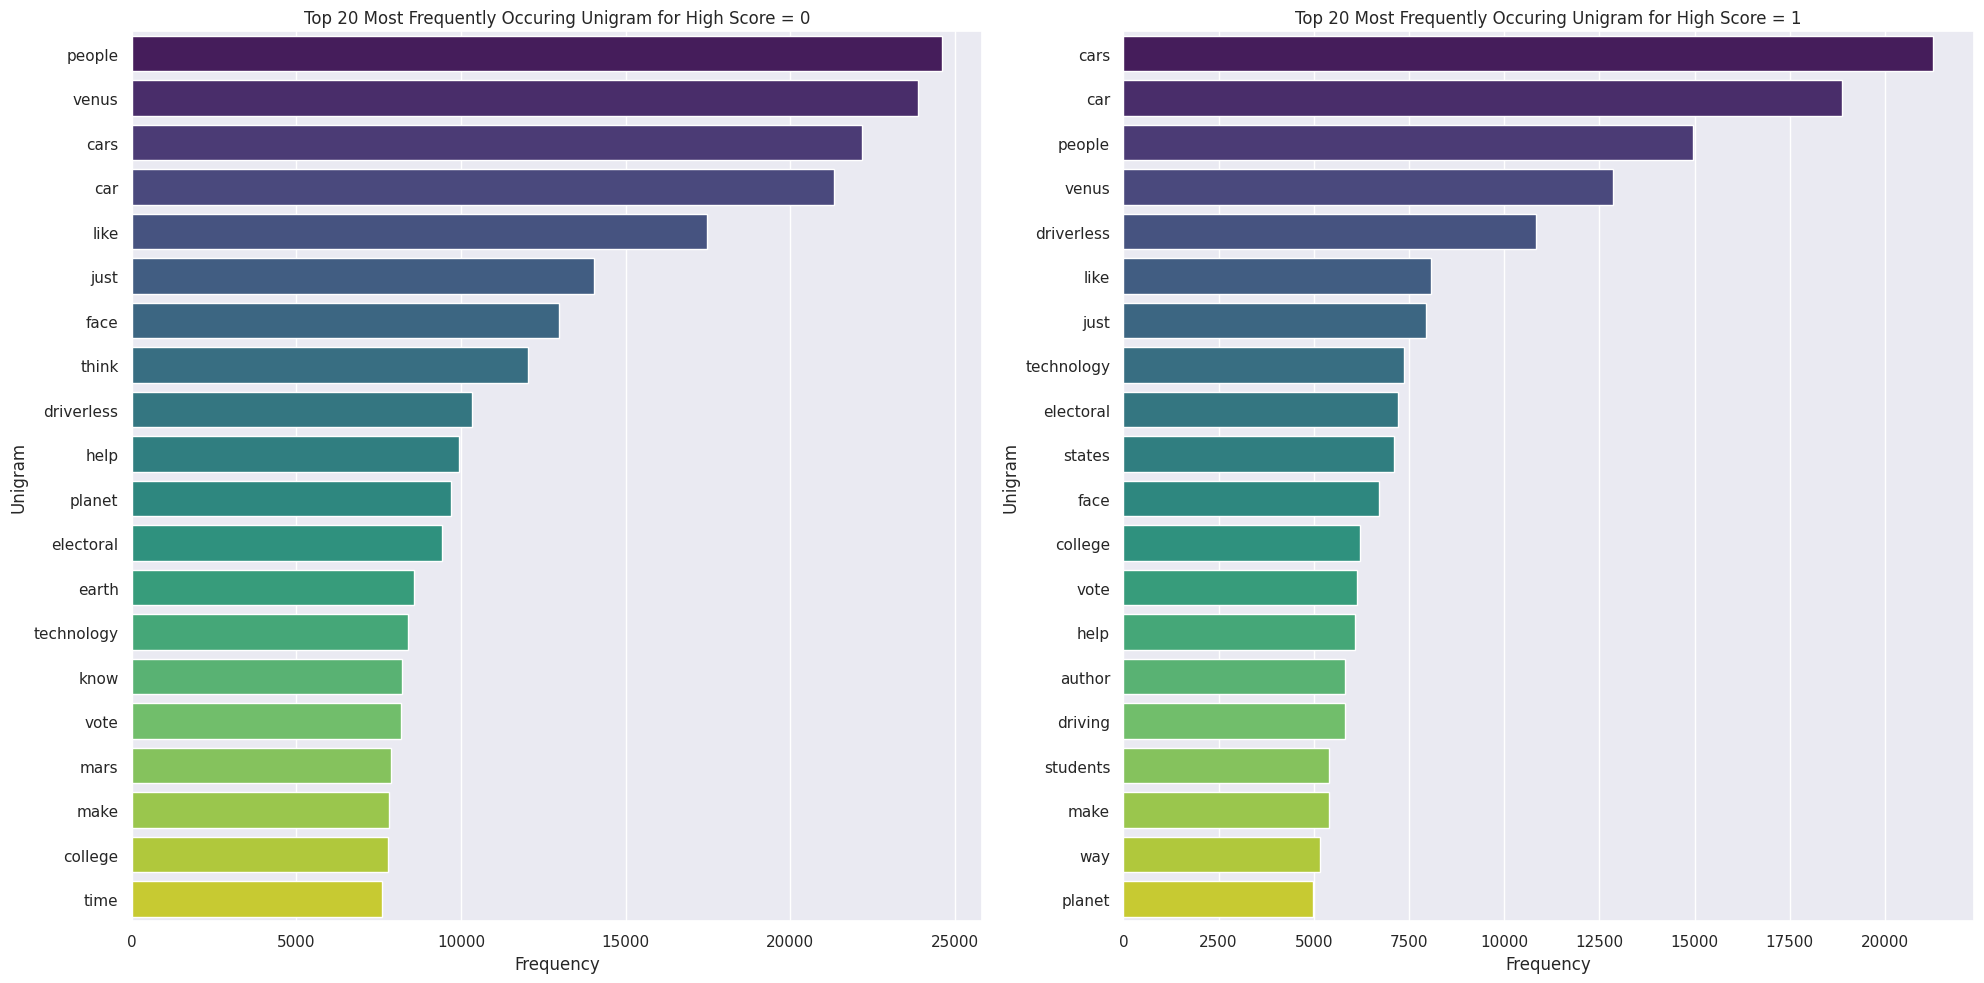

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flatten()

for i, high_score in enumerate([0, 1]):
    score_texts = data[data['high_score'] == high_score]['full_text']

    vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words = 'english')
    X = vectorizer.fit_transform(score_texts)

    sum_unigram = X.sum(axis=0)
    unigram_freq = [(word, sum_unigram[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    unigram_freq = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

    unigram_df = pd.DataFrame(unigram_freq, columns=['unigram', 'frequency'])

    sns.barplot(x='frequency', y='unigram', data=unigram_df.head(20), ax=axes[i], palette='viridis')
    axes[i].set_title(f'Top 20 Most Frequently Occuring Unigram for High Score = {high_score}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Unigram')

plt.tight_layout()
# plt.savefig('chart/1gram_high_score.svg')
plt.show()

#### **Bigrams**

In [63]:
vec = CountVectorizer(ngram_range=(2,2)).fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
top_20_words2 = pd.DataFrame(words_freq[:20], columns=['word', 'freq'])

vec_sw = CountVectorizer(ngram_range=(2,2), stop_words = 'english').fit(texts)
bag_of_words_sw = vec_sw.transform(texts)
sum_words_sw = bag_of_words_sw.sum(axis=0)
words_freq_sw = [(word, sum_words_sw[0, idx]) for word, idx in vec_sw.vocabulary_.items()]
words_freq_sw = sorted(words_freq_sw, key = lambda x: x[1], reverse=True)
top_20_words_sw2 = pd.DataFrame(words_freq_sw[:20], columns=['word', 'freq'])

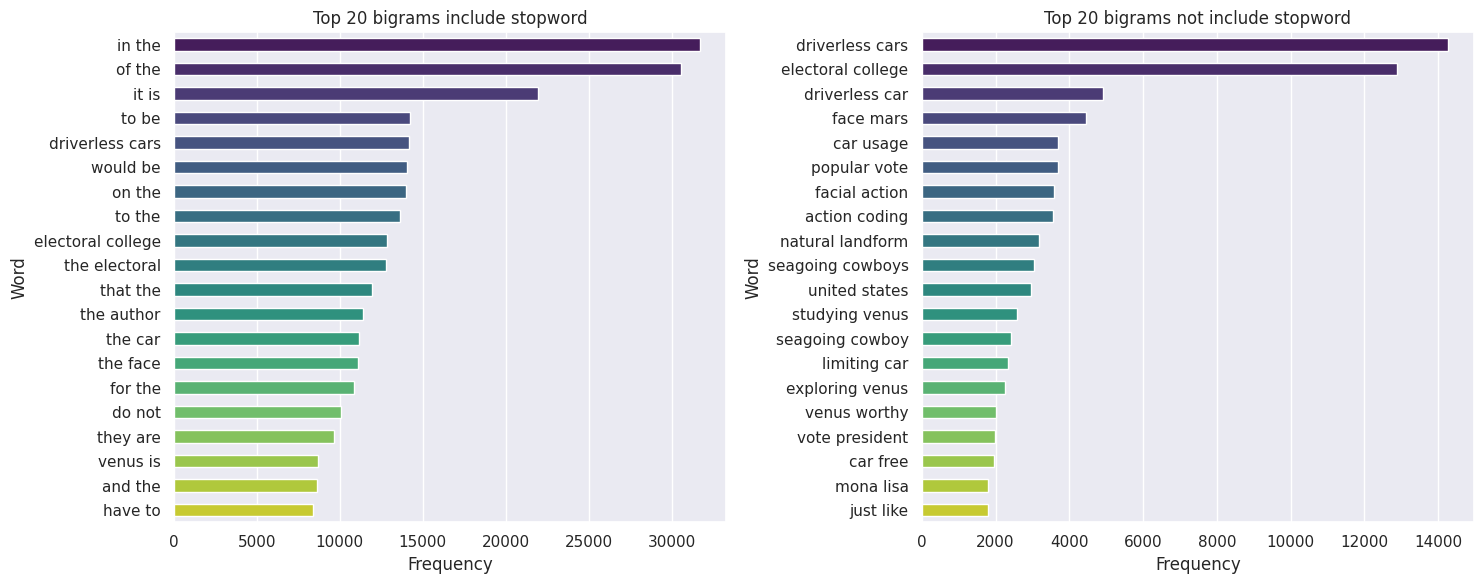

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='freq', y='word', data=top_20_words2, orient='h', ax=ax[0], width=0.5, palette='viridis')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Word')
ax[0].set_title('Top 20 bigrams include stopword')

sns.barplot(x='freq', y='word', data=top_20_words_sw2, orient='h', ax=ax[1], width=0.5, palette='viridis')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Word')
ax[1].set_title('Top 20 bigrams not include stopword')
plt.tight_layout()
# plt.savefig('chart/2gram.svg')
plt.show()

**Nhận xét:**

- So với mô hình unigram, tần suất ở mô hình bigram giảm đi khá nhiều.
- Stopword được dùng nhiều nhất là '**in the**', lên đến 30000 lần, gấp đôi lần '**driveless cars**' (từ có số lần xuất hiện nhiều nhất sau khi loại bỏ stopword).
- Các cặp bigram phổ biến khi chưa loại bỏ stopword: gồm các **giới từ, and, that, the**.
- Biểu đồ bigram có sự khác biệt lớn sau khi loại bỏ các stopword. Biểu đồ bên phải thấy được phần lớn các essay là về chủ đề **car**.

**Ta sẽ tìm hiểu sâu hơn về từng mức điểm của bài luận (khi đã loại bỏ những stopwords)**


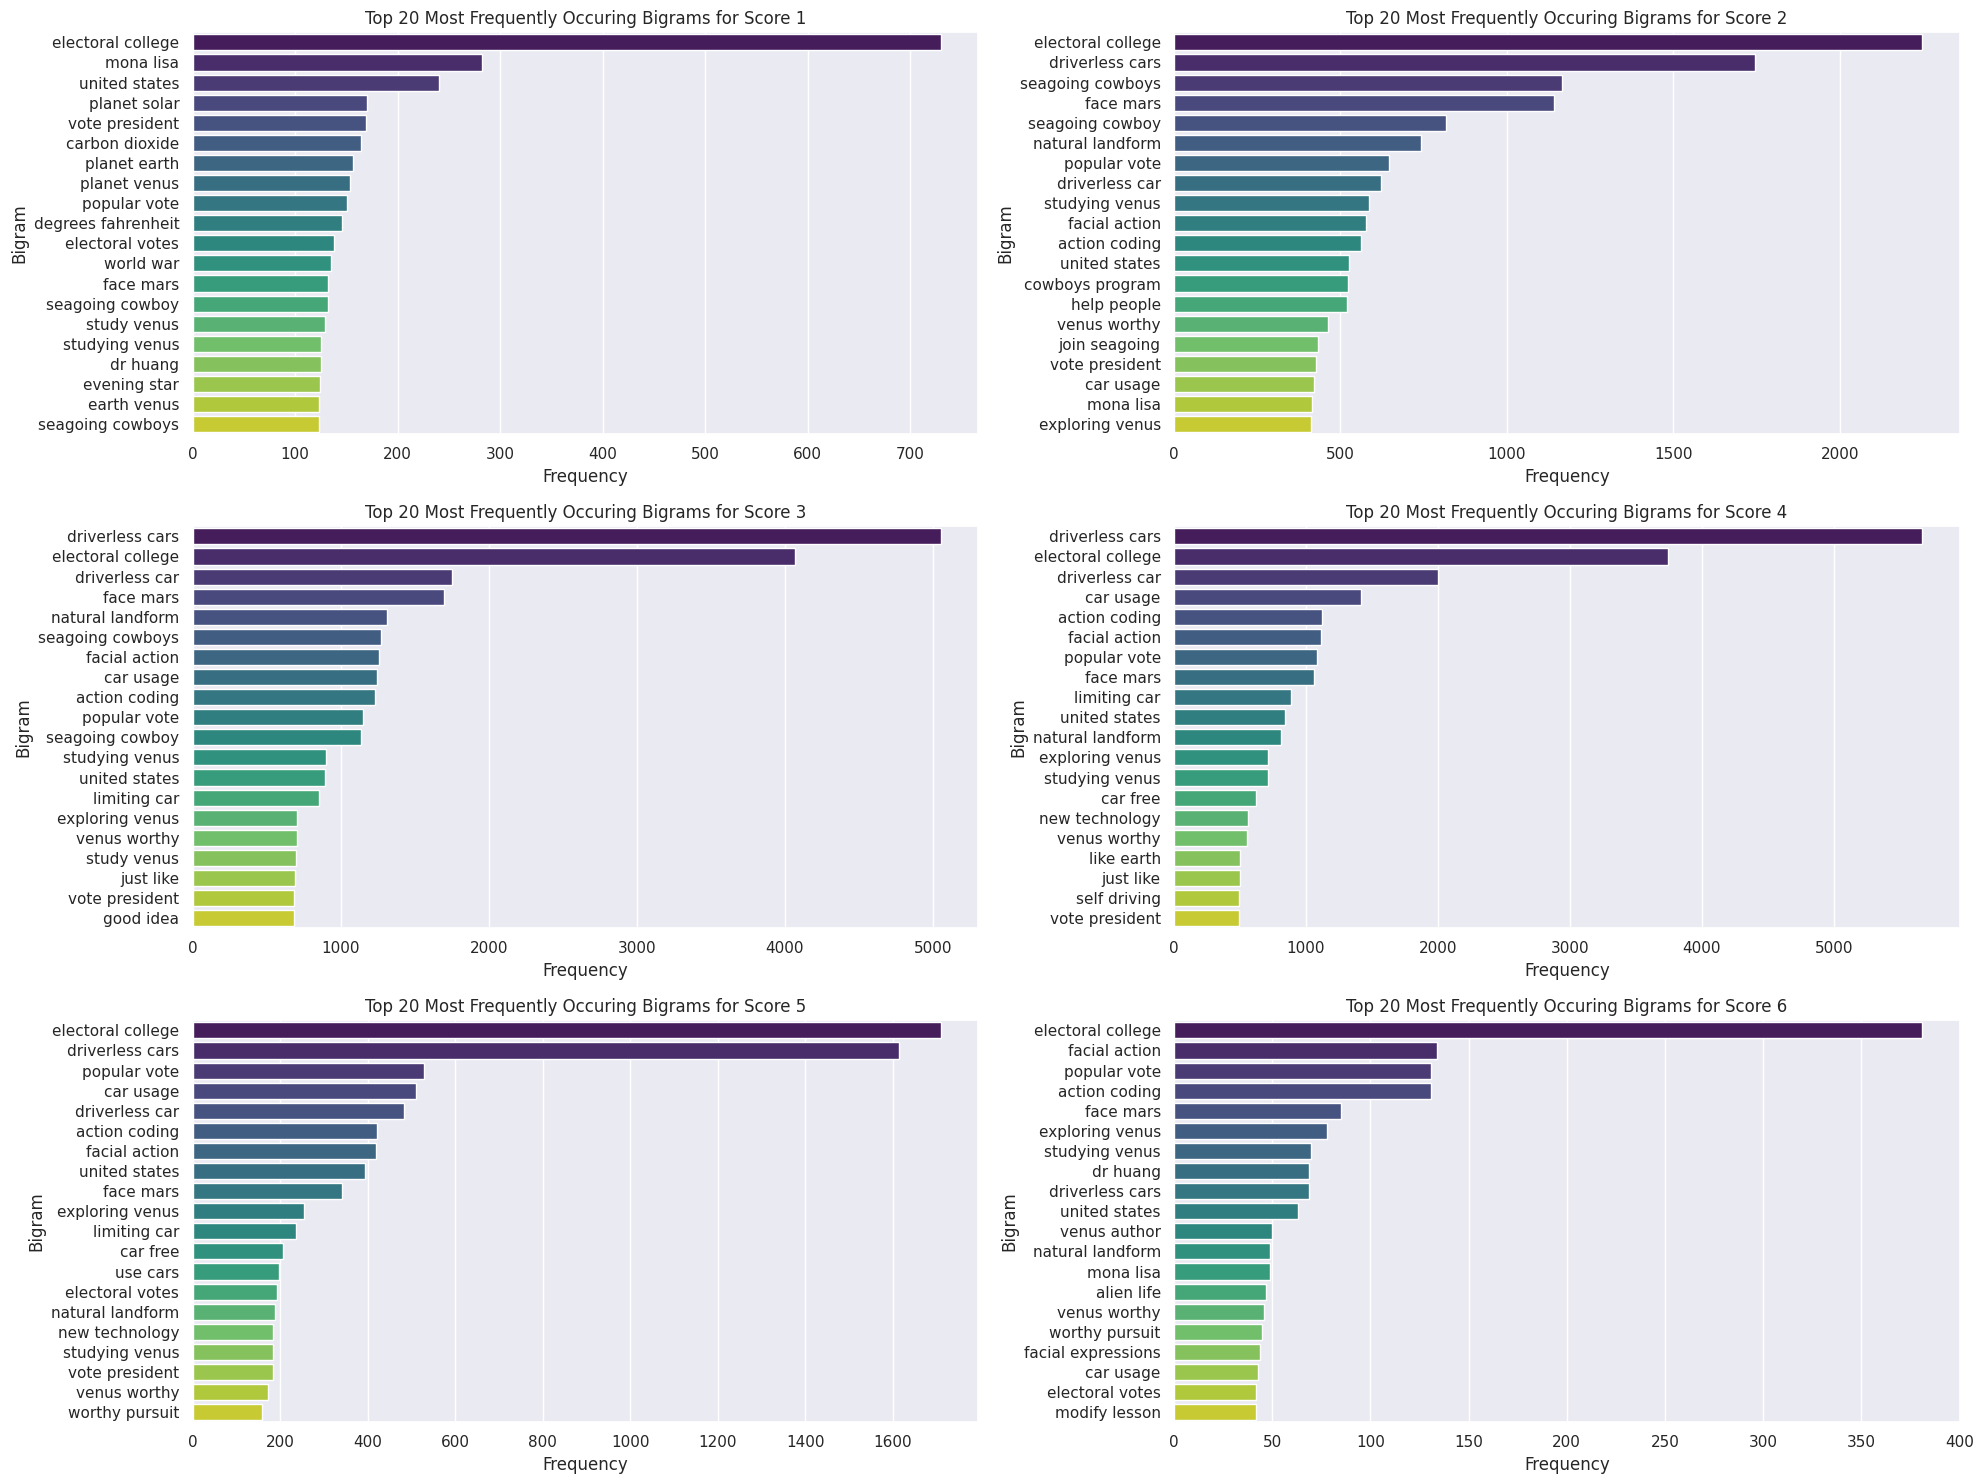

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axes = axes.flatten()

for score in range(1, 7):
    score_texts = data[data['score'] == score]['full_text']
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words = 'english')
    X = vectorizer.fit_transform(score_texts)

    sum_bigrams = X.sum(axis=0)
    bigrams_freq = [(word, sum_bigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)

    bigrams_df = pd.DataFrame(bigrams_freq, columns=['bigram', 'frequency'])

    sns.barplot(x='frequency', y='bigram', data=bigrams_df.head(20), ax=axes[score-1], palette='viridis')
    axes[score-1].set_title(f'Top 20 Most Frequently Occuring Bigrams for Score {score}')
    axes[score-1].set_xlabel('Frequency')
    axes[score-1].set_ylabel('Bigram')

plt.tight_layout()
# plt.savefig('chart/2gram_score.svg')
plt.show()

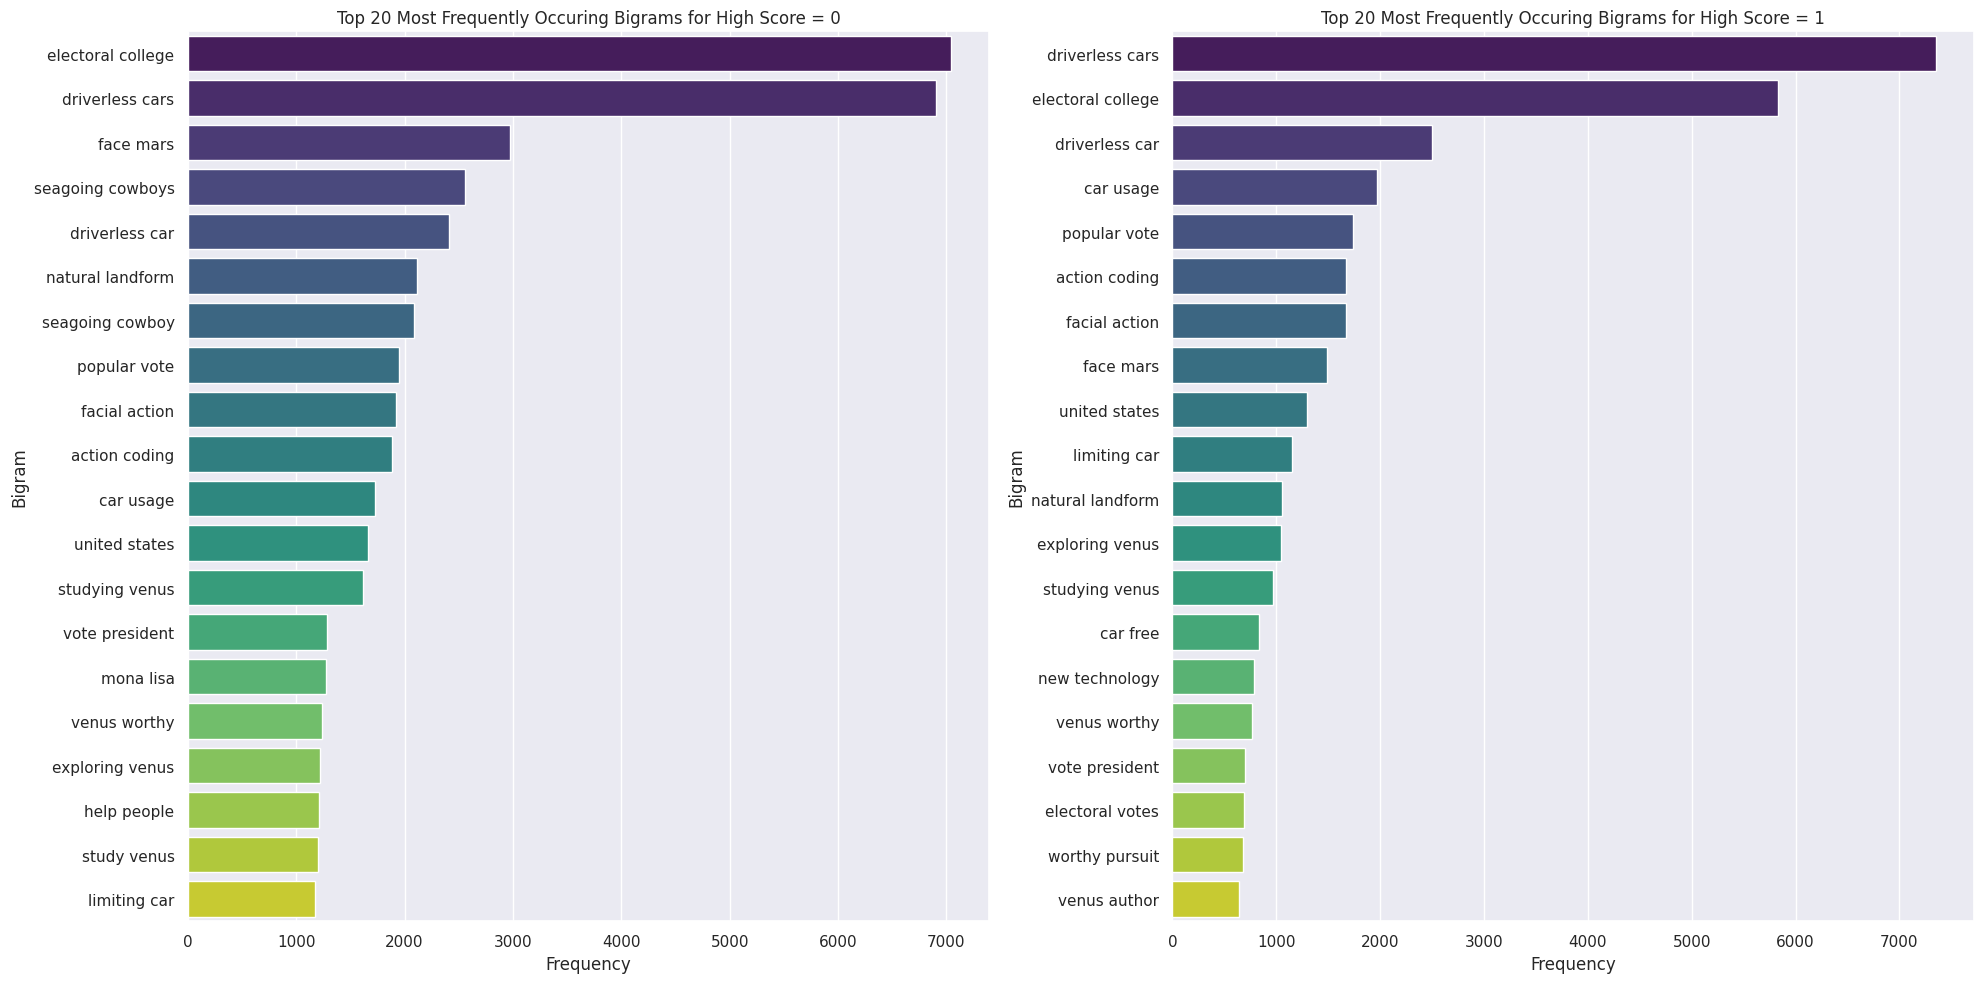

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flatten()

for i, high_score in enumerate([0, 1]):
    score_texts = data[data['high_score'] == high_score]['full_text']

    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words = 'english')
    X = vectorizer.fit_transform(score_texts)

    sum_bigrams = X.sum(axis=0)
    bigrams_freq = [(word, sum_bigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)

    bigrams_df = pd.DataFrame(bigrams_freq, columns=['bigram', 'frequency'])

    sns.barplot(x='frequency', y='bigram', data=bigrams_df.head(20), ax=axes[i], palette='viridis')
    axes[i].set_title(f'Top 20 Most Frequently Occuring Bigrams for High Score = {high_score}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Bigram')

plt.tight_layout()
# plt.savefig('chart/2gram_highscore.svg')
plt.show()

#### **Trigrams**

In [67]:
vec = CountVectorizer(ngram_range=(3,3)).fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
top_20_words3 = pd.DataFrame(words_freq[:20], columns=['word', 'freq'])

vec_sw = CountVectorizer(ngram_range=(3,3), stop_words = 'english').fit(texts)
bag_of_words_sw = vec_sw.transform(texts)
sum_words_sw = bag_of_words_sw.sum(axis=0)
words_freq_sw = [(word, sum_words_sw[0, idx]) for word, idx in vec_sw.vocabulary_.items()]
words_freq_sw = sorted(words_freq_sw, key = lambda x: x[1], reverse=True)
top_20_words_sw3 = pd.DataFrame(words_freq_sw[:20], columns=['word', 'freq'])

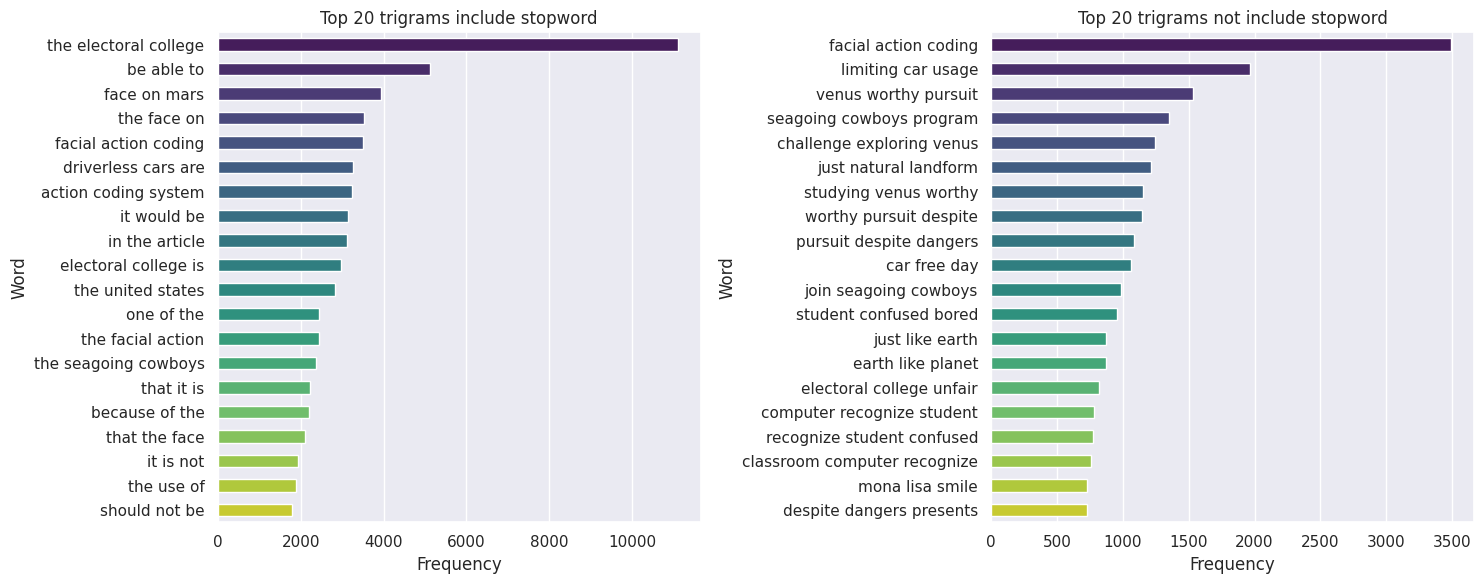

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='freq', y='word', data=top_20_words3, orient='h', ax=ax[0], width=0.5, palette='viridis')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Word')
ax[0].set_title('Top 20 trigrams include stopword')

sns.barplot(x='freq', y='word', data=top_20_words_sw3, orient='h', ax=ax[1], width=0.5, palette='viridis')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Word')
ax[1].set_title('Top 20 trigrams not include stopword')
plt.tight_layout()
# plt.savefig('chart/3gram.svg')
plt.show()

**Nhận xét:**

- So với hai mô hình trên, tần suất ở mô hình triigram giảm đi khá nhiều.
- Các stopword xuất hiện trong mô hình trigram giảm đáng kể.
- Top 20 các từ sử dụng nhiều nhất ở biểu đồ bên trái đều là từ có nghĩa, có thể hình dung được từ đó nói về những gì.
- Khi tăng số lượng n-grams, ta có hình dung được các chủ đề hay xuất hiện trong đoạn văn: **car, planet, school**... (hai mô hình trước ta chỉ thấy được chủ đề car).

**Ta sẽ tìm hiểu sâu hơn về từng mức điểm của bài luận (khi đã loại bỏ những stopwords)**


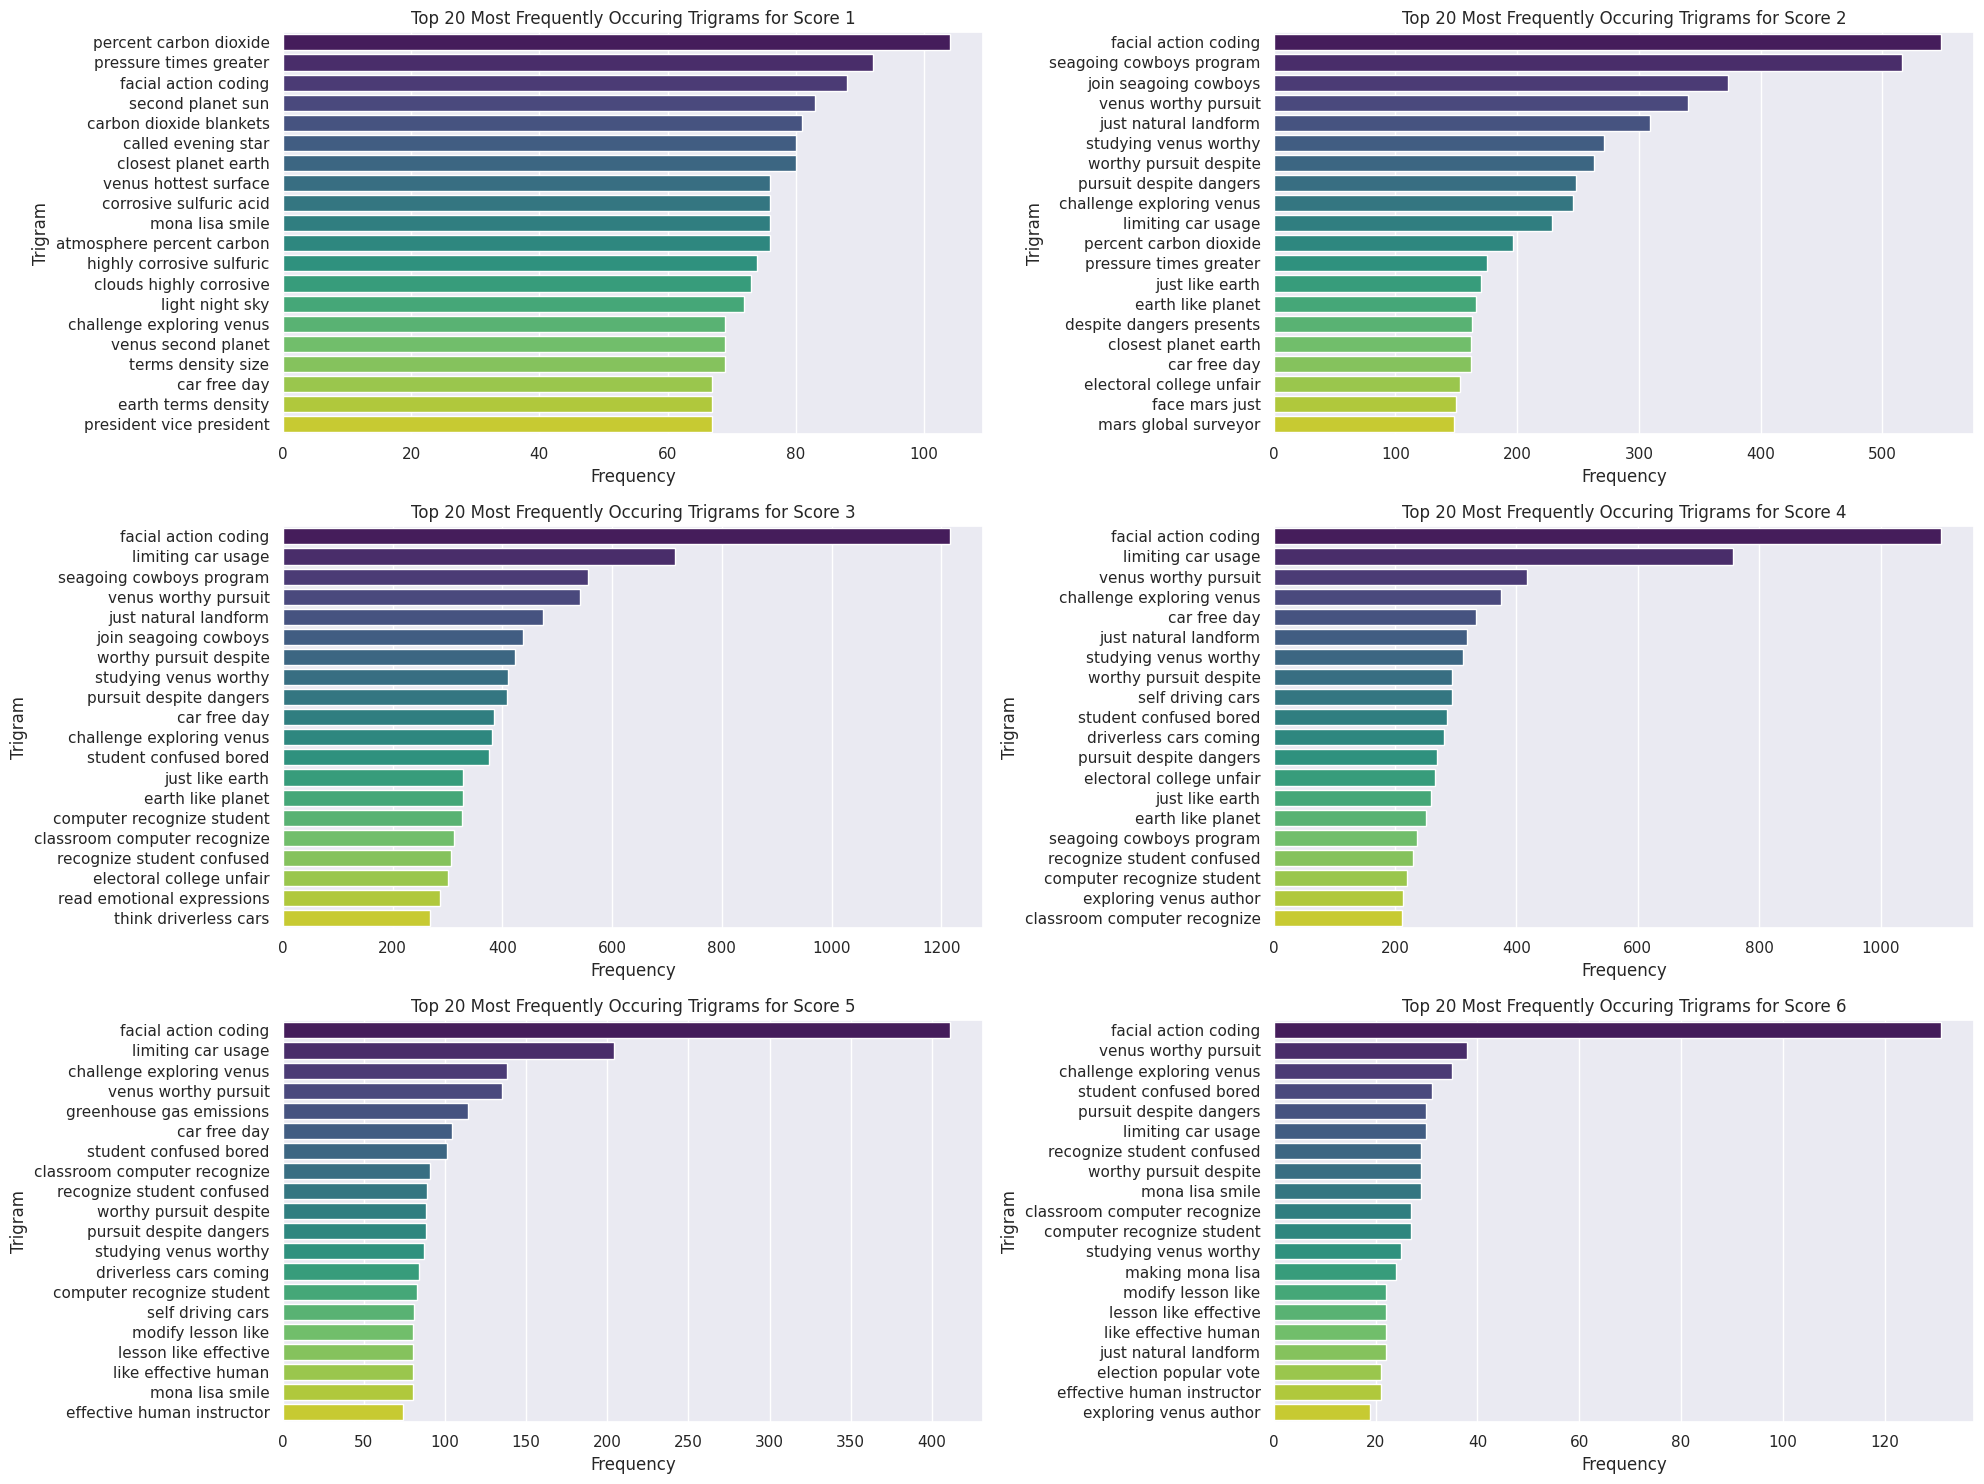

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axes = axes.flatten()

for score in range(1, 7):
    score_texts = data[data['score'] == score]['full_text']
    vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words = 'english')
    X = vectorizer.fit_transform(score_texts)

    sum_trigrams = X.sum(axis=0)
    trigrams_freq = [(word, sum_trigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    trigrams_freq = sorted(trigrams_freq, key=lambda x: x[1], reverse=True)

    trigrams_df = pd.DataFrame(trigrams_freq, columns=['trigram', 'frequency'])

    sns.barplot(x='frequency', y='trigram', data=trigrams_df.head(20), ax=axes[score-1], palette='viridis')
    axes[score-1].set_title(f'Top 20 Most Frequently Occuring Trigrams for Score {score}')
    axes[score-1].set_xlabel('Frequency')
    axes[score-1].set_ylabel('Trigram')

plt.tight_layout()
# plt.savefig('chart/3gram_score.svg')
plt.show()

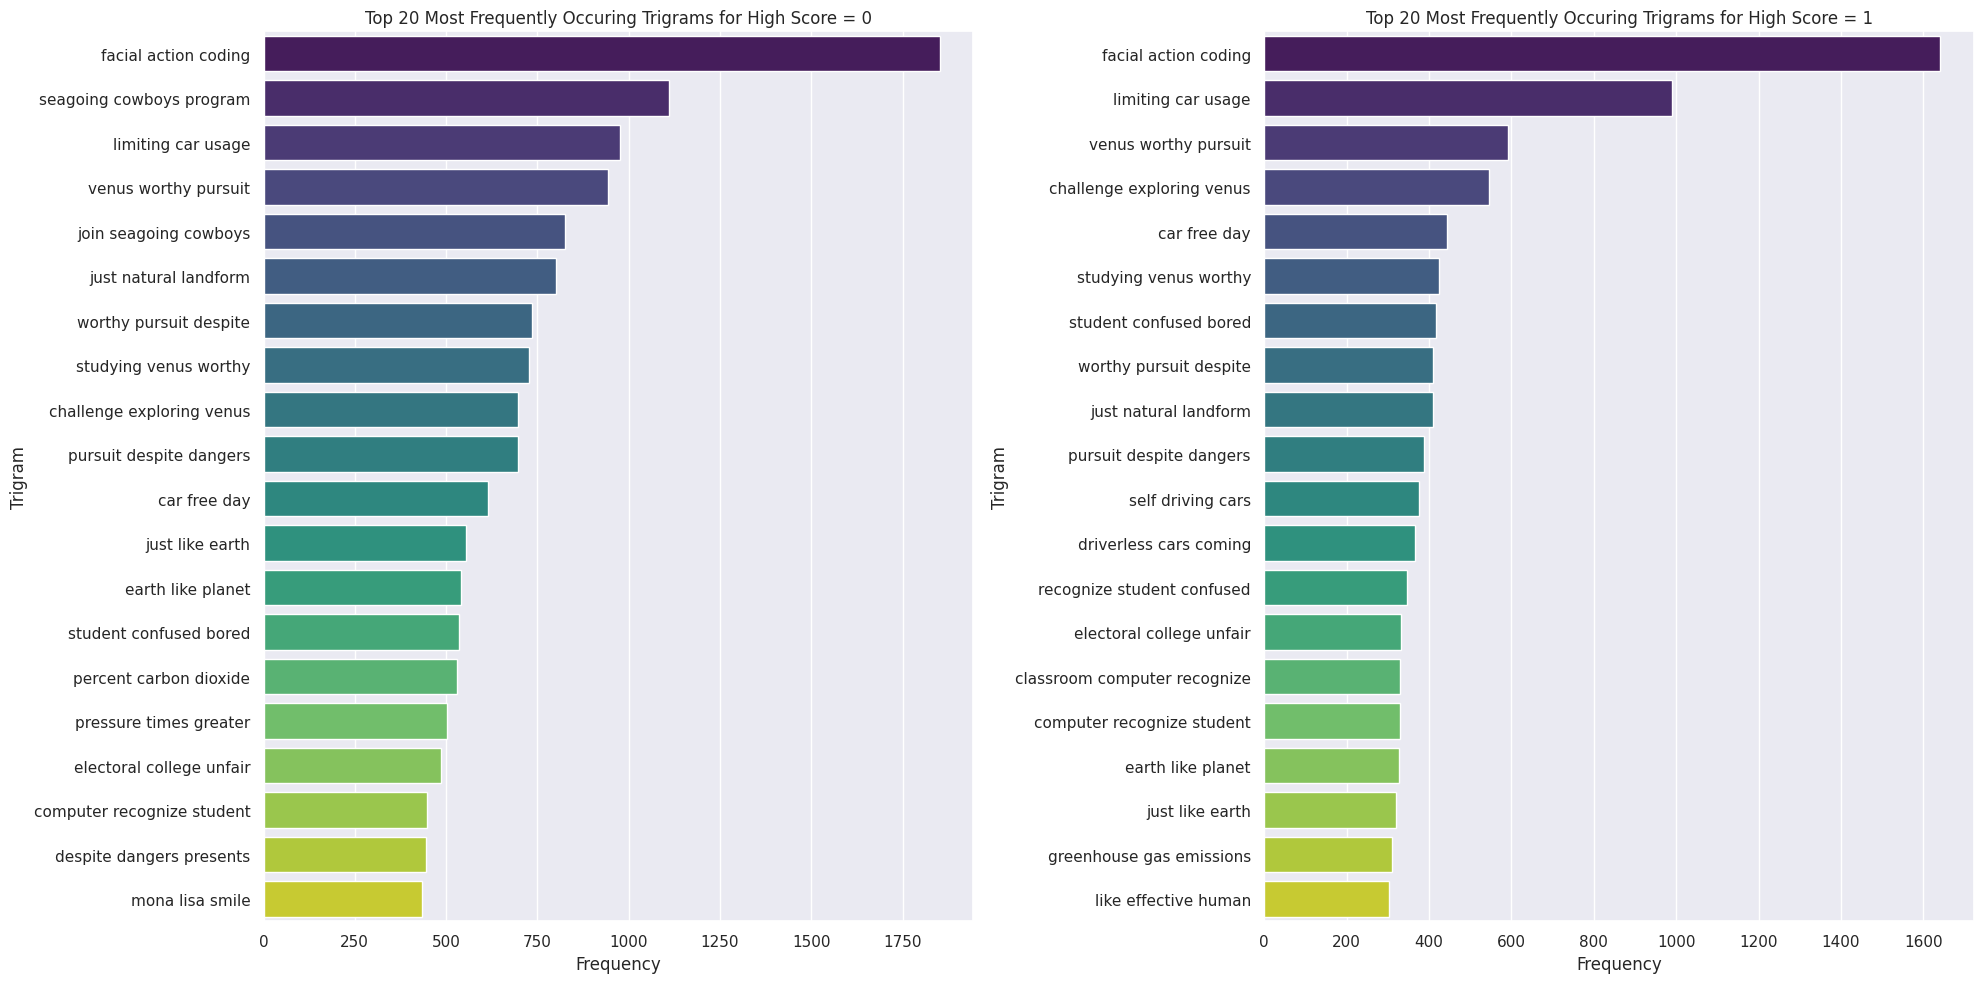

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flatten()

for i, high_score in enumerate([0, 1]):
    score_texts = data[data['high_score'] == high_score]['full_text']

    vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words = 'english')
    X = vectorizer.fit_transform(score_texts)

    sum_trigrams = X.sum(axis=0)
    trigrams_freq = [(word, sum_trigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    trigrams_freq = sorted(trigrams_freq, key=lambda x: x[1], reverse=True)

    trigrams_df = pd.DataFrame(trigrams_freq, columns=['trigram', 'frequency'])

    sns.barplot(x='frequency', y='trigram', data=trigrams_df.head(20), ax=axes[i], palette='viridis')
    axes[i].set_title(f'Top 20 Most Frequently Occuring Trigrams for High Score = {high_score}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Trigram')

plt.tight_layout()
# plt.savefig('chart/3gram_highscore.svg')
plt.show()

### **11. Phân tích nội dung**

In [71]:
from wordcloud import WordCloud

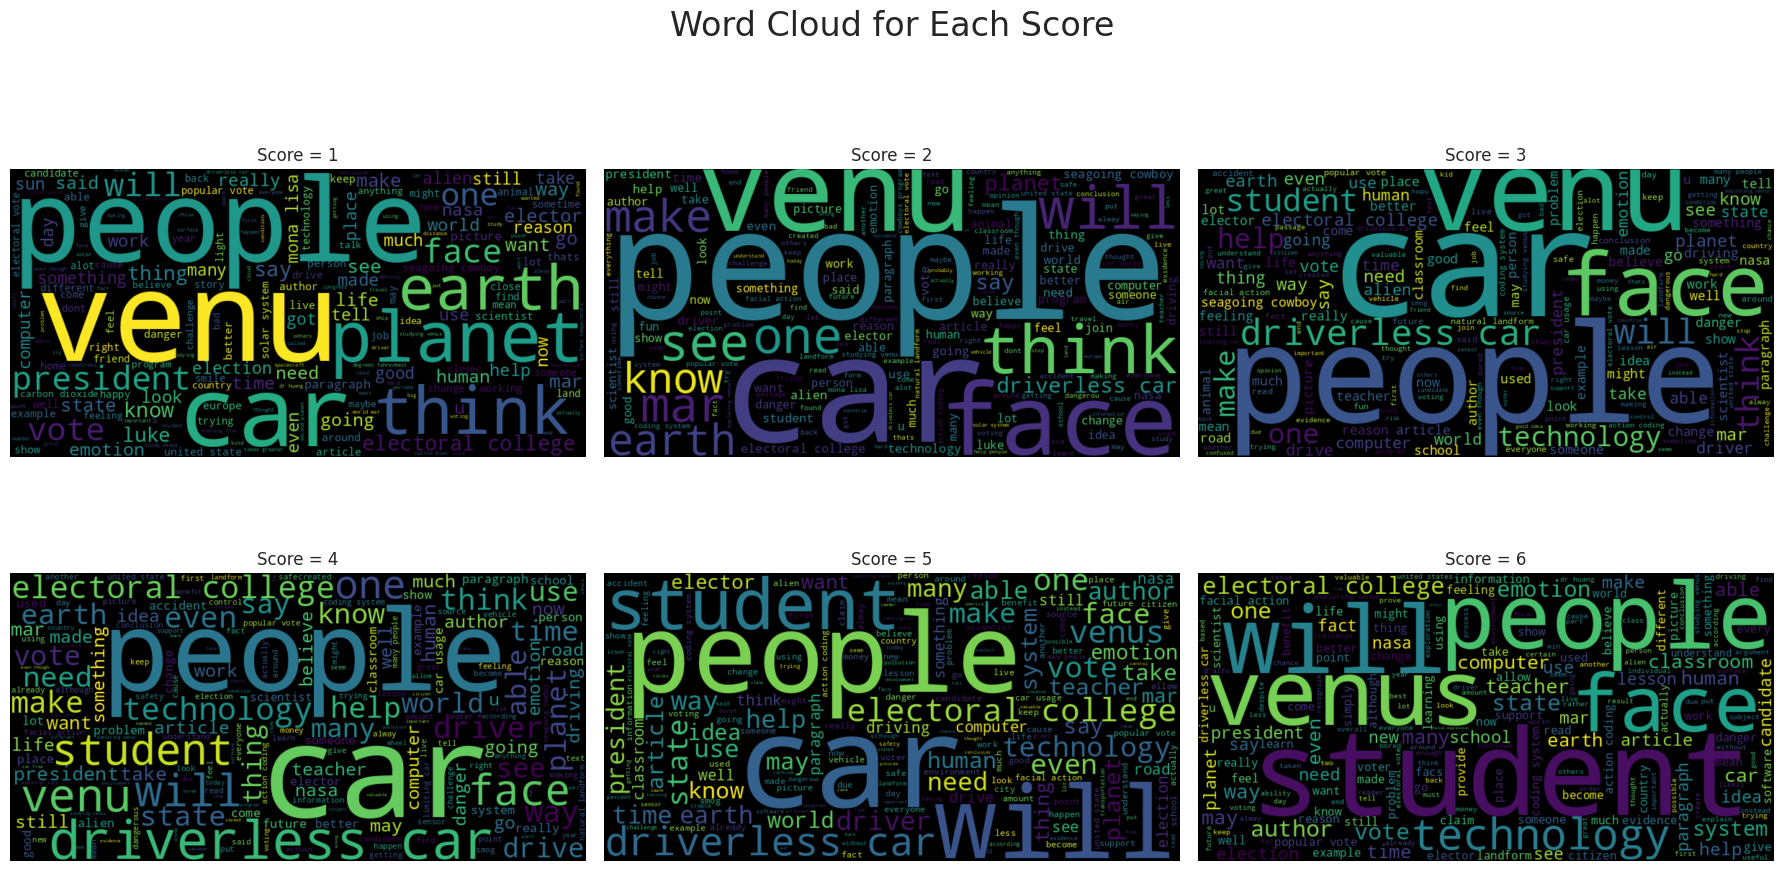

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for score in range(1, 7):
    score_texts = data[data['score'] == score]['full_text']
    combined_text = " ".join(score_texts)

    if combined_text:
        wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)
        axes[score-1].imshow(wordcloud, interpolation='bilinear')
        axes[score-1].axis('off')
        axes[score-1].set_title(f"Score = {score}")

fig.suptitle('Word Cloud for Each Score', fontsize=24)
plt.tight_layout()
# plt.savefig('chart/wordcloud_score.svg')
plt.show()

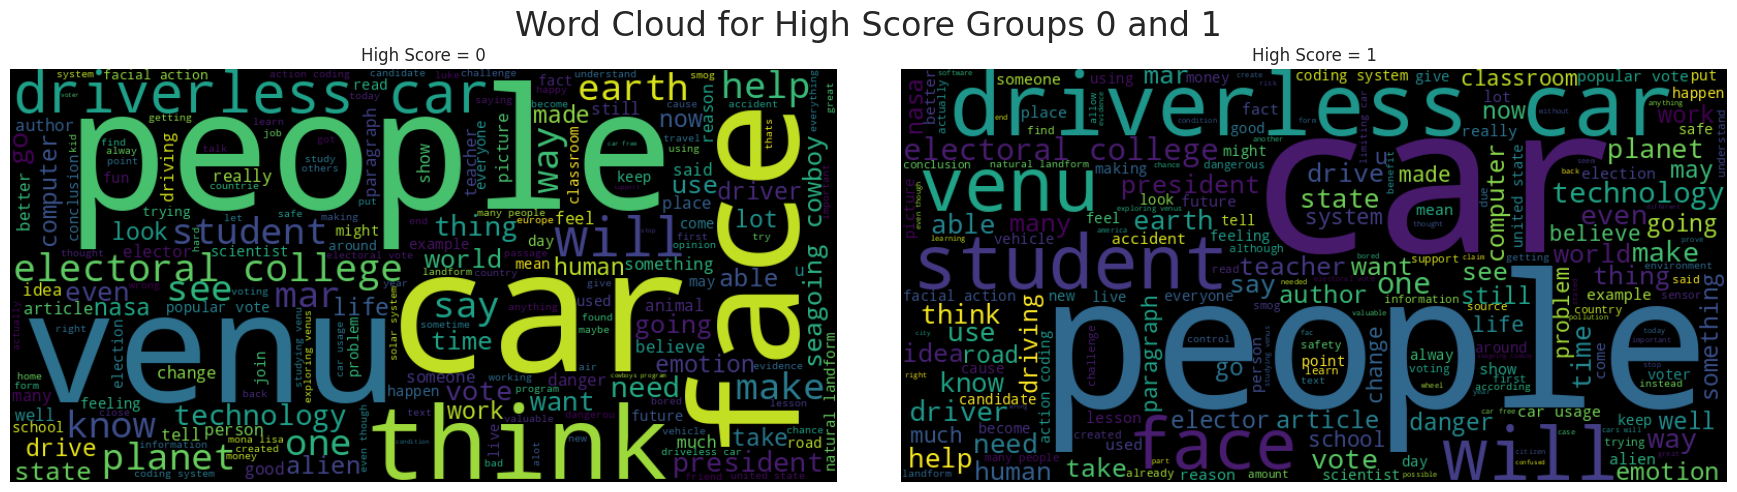

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for idx, score in enumerate([0, 1]):
    score_texts = data[data['high_score'] == score]['full_text']
    combined_text = " ".join(score_texts)

    if combined_text:
        wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f"High Score = {score}")

fig.suptitle('Word Cloud for High Score Groups 0 and 1', fontsize=24)
plt.tight_layout()
# plt.savefig('chart/wordcloud_highscore.svg')
plt.show()

Nhận xét:
- Bằng wordcloud có thể nhận ra một số từ được dùng nhiều ví dụ như : car, people..
- Wordcloud cho ta một cái nhìn tổng thể về tần suất, có thể thấy từ dùng nhiều nhất bởi nó có kích cỡ to nhất. Tuy nhiên nó chỉ có tác dụng trực quan, không có số liệu rõ ràng để ta phân tích.

&rarr; Ta thường ưu tiên mô hình N-gram để có cái nhìn rõ hơn về các số liệu của dữ liệu.


In [74]:
# !zip -r /content/chart.zip /content/chart